In [23]:
# Configuration and Constants
# This cell sets up paths, constants, and random seeds for reproducibility

import os
import random
import numpy as np
from pathlib import Path

# === Path Configuration ===
# Use relative paths from notebook location for portability
# Get current working directory (should be project root or notebooks folder)
current_dir = Path(os.getcwd())

# Determine project root based on current directory
if current_dir.name == 'notebooks':
    # Already in notebooks folder
    PROJECT_ROOT = current_dir.parent
elif (current_dir / 'notebooks').exists():
    # In project root
    PROJECT_ROOT = current_dir
else:
    # Fallback: assume we're in project root
    PROJECT_ROOT = current_dir

DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")

# === Analysis Constants ===
# Outlier Detection
IQR_MULTIPLIER = 1.5  # Multiplier for IQR method (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
RESIDUAL_OUTLIER_THRESHOLD = 2  # Standard deviations for residual outliers

# Visualization
HISTOGRAM_BINS = 30
FIGURE_DPI = 100

# Model Training
TEST_SIZE = 0.3  # 30% test set, 70% training set
RANDOM_STATE = 42  # For reproducibility
CV_FOLDS = 5  # K-fold cross-validation folds

# === Random Seeds for Reproducibility ===
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

print(f"\n✓ Configuration complete. Random seed set to {RANDOM_STATE}")

Project Root: c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction
Data Directory: c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\data
Output Directory: c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output

✓ Configuration complete. Random seed set to 42


# Medical Insurance Premium Prediction Analysis

## Project Overview
This notebook analyzes medical insurance premium data to build a predictive model for premium pricing. The analysis follows best practices for data science workflows including:

1. **Data Loading & Inspection** - Understanding the dataset structure and quality
2. **Exploratory Data Analysis** - Identifying patterns, correlations, and relationships
3. **Feature Engineering & Selection** - Creating meaningful predictors and removing redundant features
4. **Data Preprocessing** - Handling missing values and outliers after train/test split
5. **Interaction Discovery & Stepwise Selection** - Systematic exploration of interaction terms
6. **Model Comparison Framework** - Comparing 4 regression techniques (OLS, Ridge, Lasso, ElasticNet)
7. **Statistical Testing** - Validating model assumptions and identifying influential observations
8. **Final Predictions** - Model interpretation, performance evaluation, and business insights

## Analysis Highlights
- **Dataset:** 986 observations with 11 features
- **Models Compared:** 4 regression techniques (OLS, Ridge, Lasso, ElasticNet)
- **Selected Model:** OLS Baseline (best composite score)
- **Test Set Performance:** R² = 0.702, RMSE = $3,493

- **Cross-Validation:** 5-fold CV for model stability assessment- **Interaction Analysis:** Tested but base model selected for simplicity without performance loss
- **Key Predictors:** Age, BMI, transplants, chronic diseases, family cancer history

In [24]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, shapiro, probplot
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


# Step 1: Data Loading

**Objective:** Load the medical insurance premium dataset and perform initial inspection.

**Note:** This step uses the workspace data directory structure for portability.

In [25]:
# Load the dataset from the data directory
data_file = DATA_DIR / 'Medicalpremium.csv'

try:
    df = pd.read_csv(data_file)
    print(f"✓ Dataset loaded successfully from: {data_file}")
    print(f"\nDataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print("\nFirst 5 Rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    
    # Validate expected columns exist
    expected_cols = ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 
                     'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 
                     'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice']
    missing_cols = set(expected_cols) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing expected columns: {missing_cols}")
    print("\n✓ All expected columns present")
    
except FileNotFoundError:
    print(f"✗ Error: File not found at {data_file}")
    print(f"Available files in {DATA_DIR}:")
    print(list(DATA_DIR.glob('*.csv')))
    raise
except Exception as e:
    print(f"✗ Error loading dataset: {e}")
    raise

✓ Dataset loaded successfully from: c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\data\Medicalpremium.csv

Dataset Shape: 986 rows, 11 columns

First 5 Rows:
   Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0   45         0                      0               0                   0   
1   60         1                      0               0                   0   
2   36         1                      1               0                   0   
3   52         1                      1               0                   1   
4   38         0                      0               0                   1   

   Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0     155      57               0                        0   
1     180      73               0                        0   
2     158      59               0                        0   
3     183      93               0                        0   
4     

# Step 2: Initial Data Inspection

**Objective:** Understand the data structure, identify missing values, and examine distributions.

**⚠️ Important:** We do NOT impute missing values or engineer features yet to avoid data leakage. That happens in Step 4 AFTER train/test split.

DATA INSPECTION

Dataset Shape: (986, 11)

Data Types and Non-Null Counts:
<class 'pandas.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB
None

MISSING VALUES ANALYSIS
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

✓ No missing values d

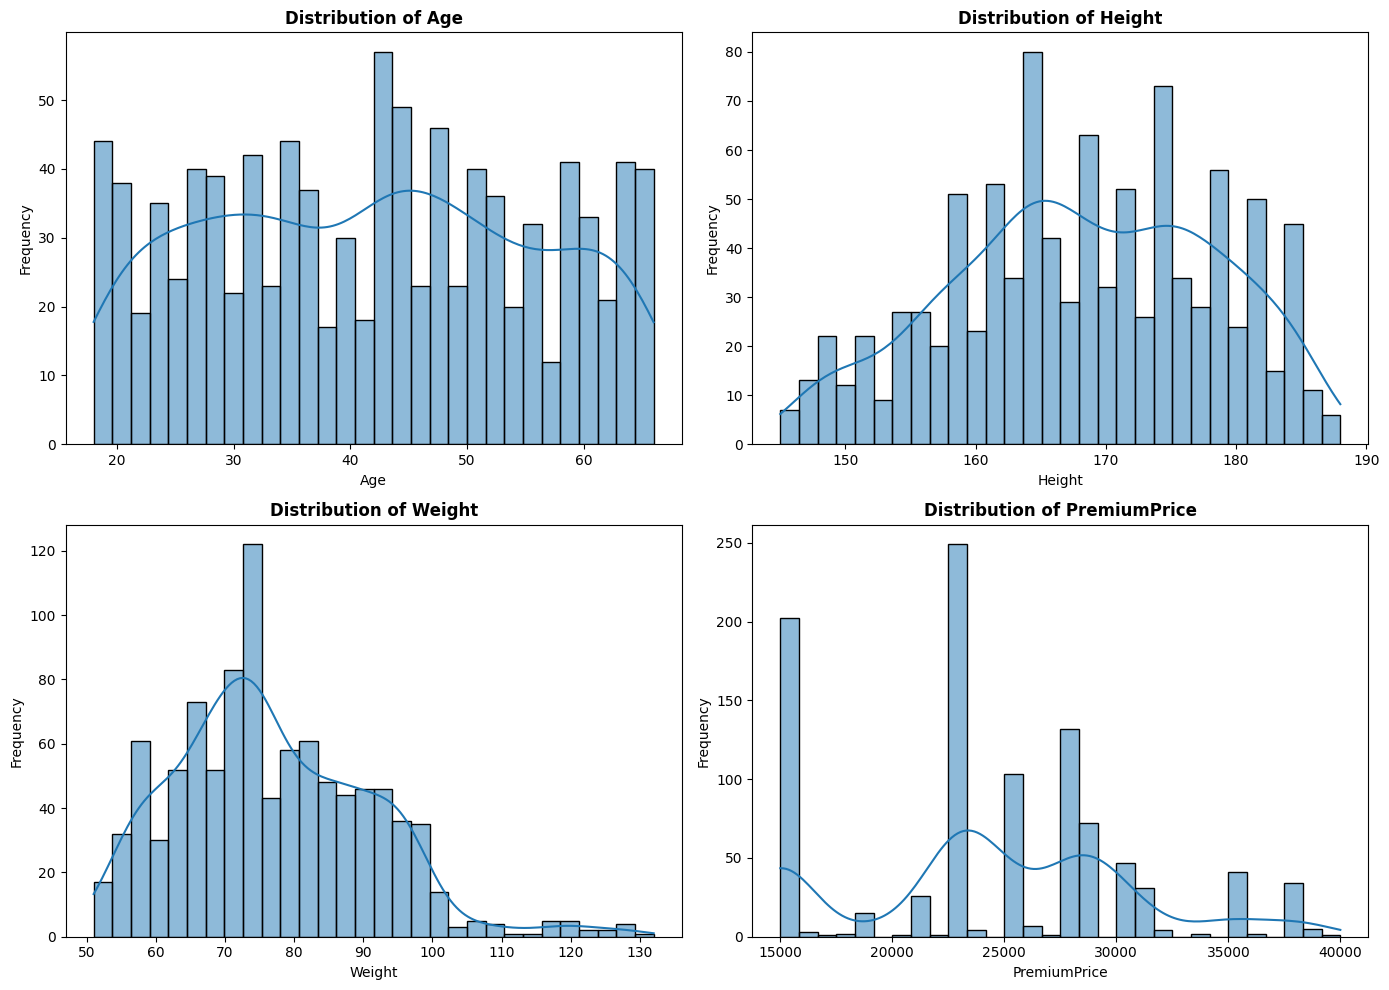

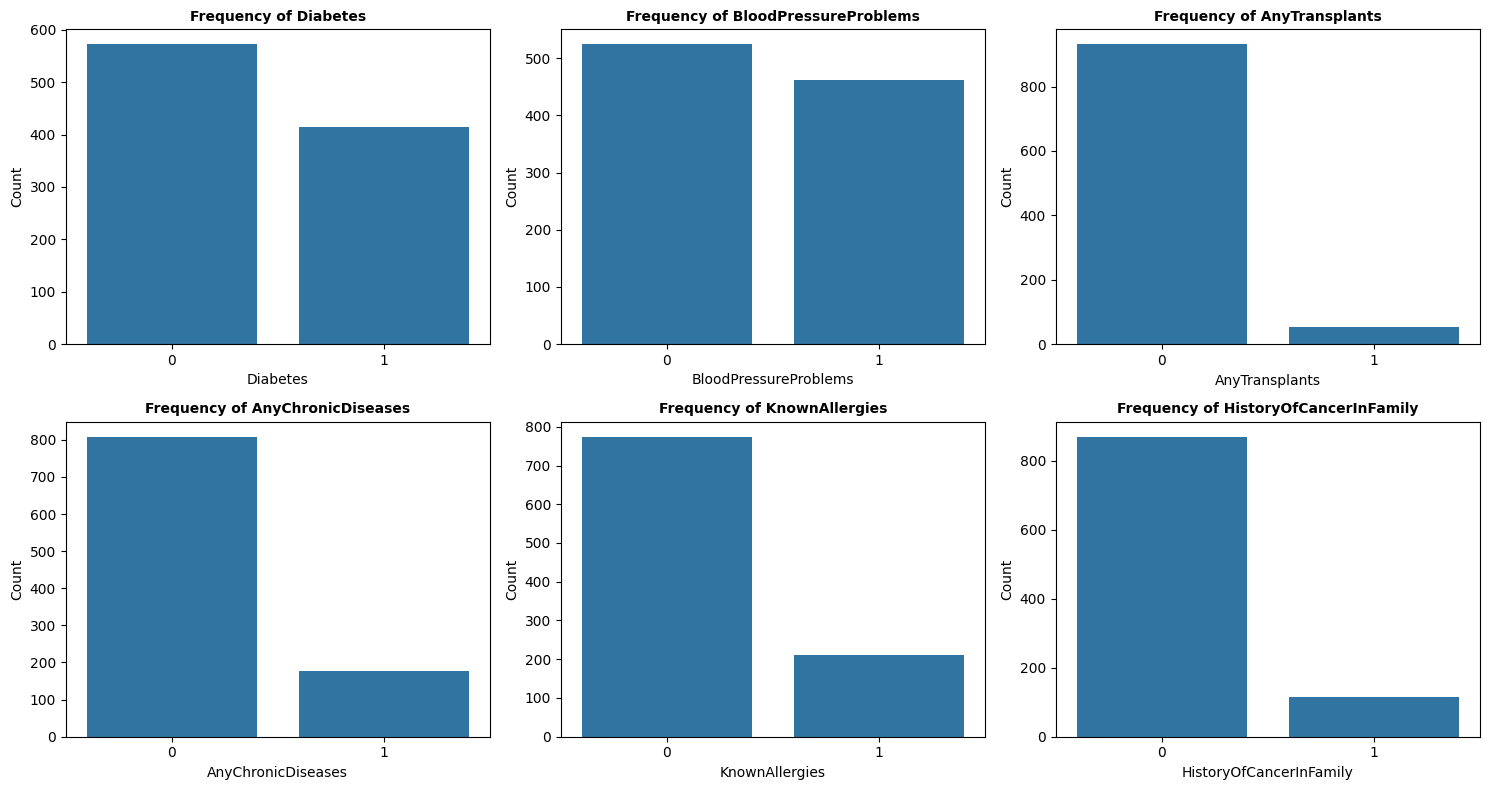

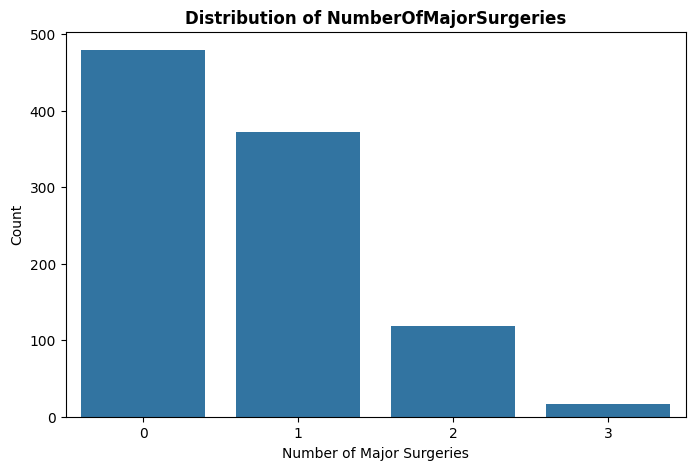


✓ Distribution plots saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output

⚠️ Note: No data transformations applied yet (avoiding data leakage)


In [26]:
# 2.1 Inspect Data Structure and Missing Values
print("="*80)
print("DATA INSPECTION")
print("="*80)

print("\nDataset Shape:", df.shape)
print("\nData Types and Non-Null Counts:")
print(df.info())

print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

if missing_summary.sum() == 0:
    print("\n✓ No missing values detected")
else:
    print(f"\n⚠ Total missing values: {missing_summary.sum()}")
    print("Note: Missing values will be imputed AFTER train/test split to prevent data leakage")

# 2.2 Summary Statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

continuous_vars = ['Age', 'Height', 'Weight', 'PremiumPrice']
print("\nContinuous Variables:")
print(df[continuous_vars].describe())

binary_vars = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 
               'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']
print("\nBinary Variables (Frequency Tables):")
for var in binary_vars:
    print(f"\n{var}:")
    print(df[var].value_counts(normalize=True).to_frame('Proportion'))

print("\nNumberOfMajorSurgeries Distribution:")
print(df['NumberOfMajorSurgeries'].value_counts().sort_index().to_frame('Count'))

# 2.3 Visualize Distributions (for initial understanding only)
print("\n" + "="*80)
print("GENERATING DISTRIBUTION PLOTS")
print("="*80)

# Histograms for continuous variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, var in enumerate(continuous_vars):
    sns.histplot(df[var], bins=HISTOGRAM_BINS, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step2_continuous_distributions.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# Bar plots for binary variables
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, var in enumerate(binary_vars):
    sns.countplot(x=var, data=df, ax=axes[idx])
    axes[idx].set_title(f'Frequency of {var}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step2_binary_distributions.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# NumberOfMajorSurgeries distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='NumberOfMajorSurgeries', data=df)
plt.title('Distribution of NumberOfMajorSurgeries', fontsize=12, fontweight='bold')
plt.xlabel('Number of Major Surgeries')
plt.ylabel('Count')
plt.savefig(OUTPUT_DIR / 'step2_surgeries_distribution.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

print(f"\n✓ Distribution plots saved to {OUTPUT_DIR}")
print("\n⚠️ Note: No data transformations applied yet (avoiding data leakage)")

# Step 3: Exploratory Data Analysis (EDA)

**Objective:** Visualize relationships between predictors and PremiumPrice to identify patterns, correlations, and guide feature selection.

**Key Questions:**
- Which variables show strong linear/non-linear relationships with PremiumPrice?
- Is there evidence of multicollinearity among predictors?
- Do binary variables significantly impact premium pricing?

**Note:** We create temporary BMI variable for visualization only. Actual feature engineering happens in Step 4.

EXPLORATORY DATA ANALYSIS - RELATIONSHIPS WITH PREMIUM PRICE


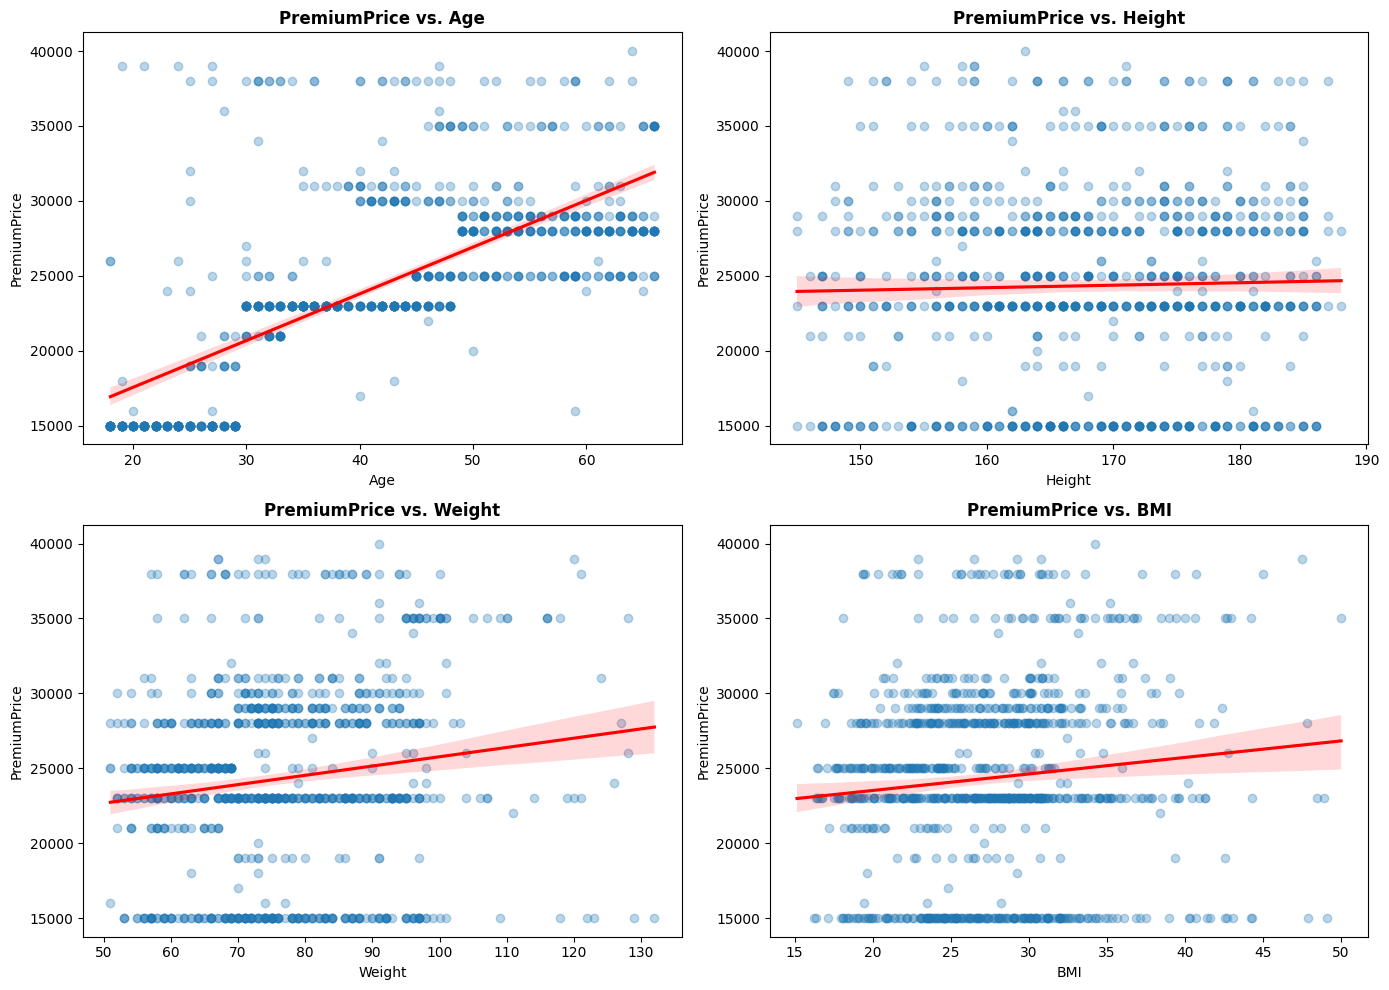

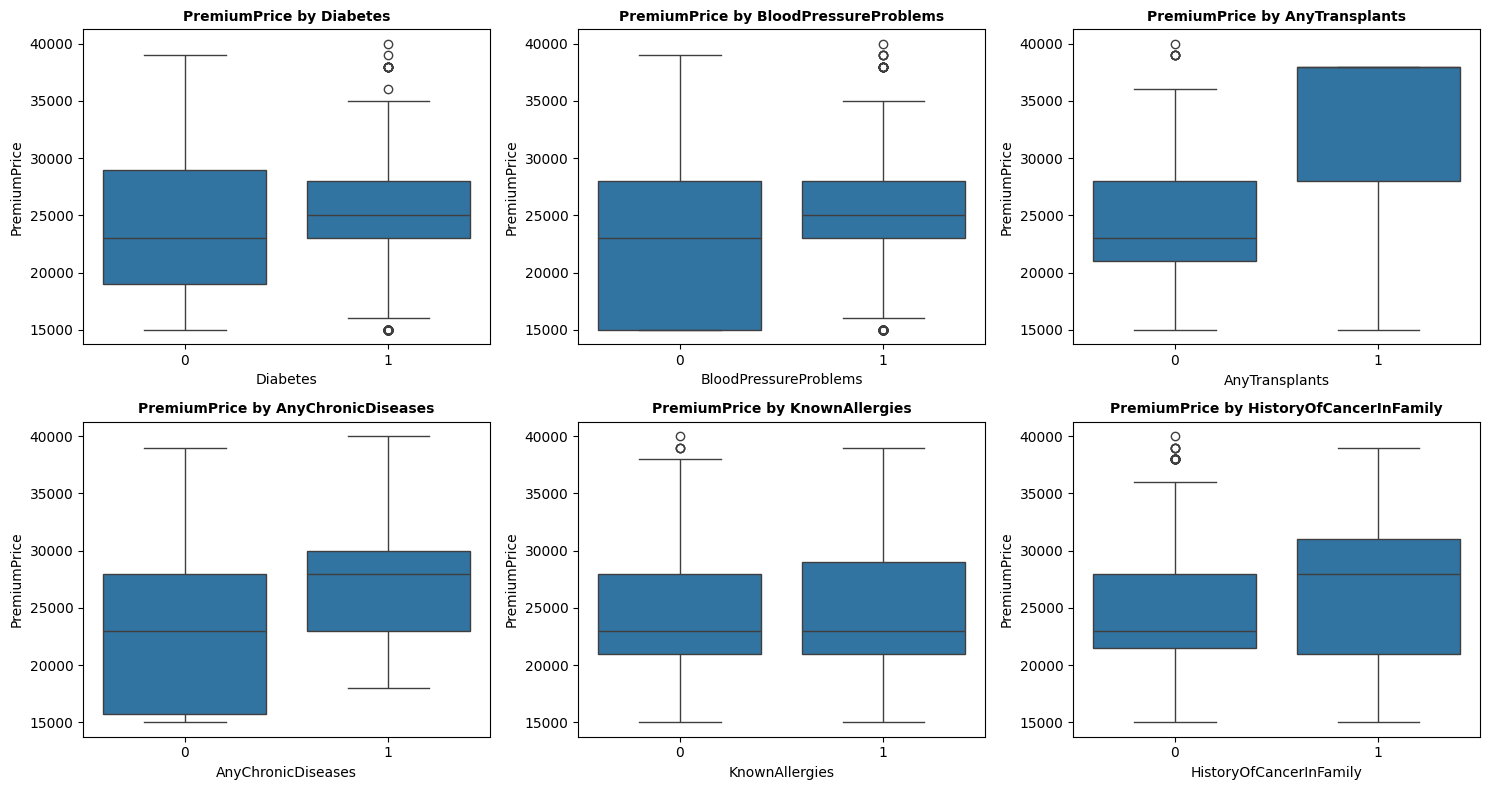

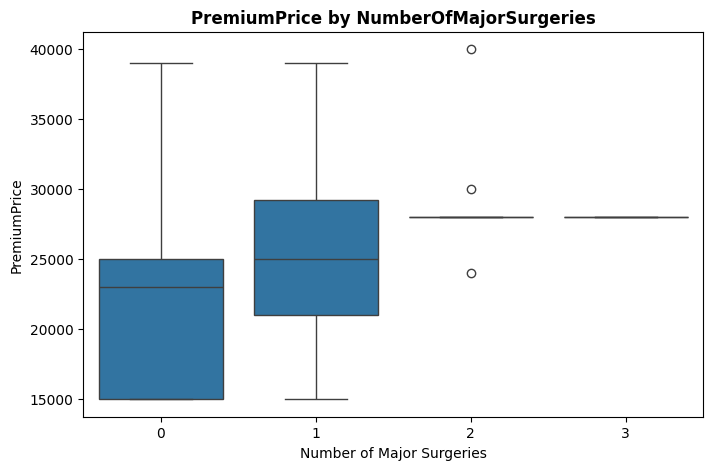


CORRELATION ANALYSIS

Pearson Correlation Matrix:
                Age  Height  Weight    BMI  PremiumPrice
Age           1.000   0.040  -0.019 -0.042         0.698
Height        0.040   1.000   0.067 -0.505         0.027
Weight       -0.019   0.067   1.000  0.821         0.142
BMI          -0.042  -0.505   0.821  1.000         0.104
PremiumPrice  0.698   0.027   0.142  0.104         1.000


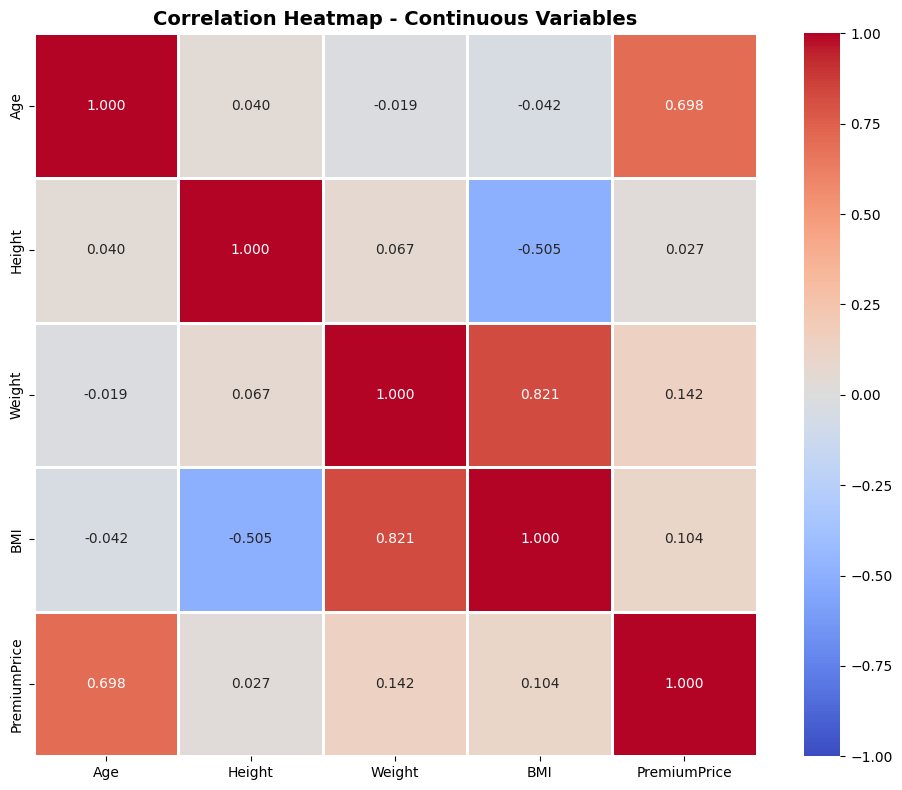


✓ Correlation matrix saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output\correlation_matrix.csv

POINT-BISERIAL CORRELATIONS (Binary Variables)
Diabetes                       | r =  0.076 | p = 0.0167 | *
BloodPressureProblems          | r =  0.167 | p = 0.0000 | ***
AnyTransplants                 | r =  0.289 | p = 0.0000 | ***
AnyChronicDiseases             | r =  0.209 | p = 0.0000 | ***
KnownAllergies                 | r =  0.012 | p = 0.7043 | ns
HistoryOfCancerInFamily        | r =  0.083 | p = 0.0090 | **

EDA KEY INSIGHTS

Findings from visualizations and correlation analysis:

1. **Multicollinearity Concern**: Height, Weight, and BMI are highly correlated (r > 0.8)
   → Solution: Use BMI only in modeling, drop Height and Weight

2. **Non-linear Patterns**: Age may show quadratic relationship with PremiumPrice
   → Solution: Consider adding Age² term in model

3. **Significant Binary Predictors**: 
   - AnyTransplant

In [27]:
# Create temporary BMI for exploratory visualization (not modifying original df)
df_explore = df.copy()
df_explore['BMI'] = df_explore['Weight'] / ((df_explore['Height'] / 100) ** 2)

print("="*80)
print("EXPLORATORY DATA ANALYSIS - RELATIONSHIPS WITH PREMIUM PRICE")
print("="*80)

# 3.1 Scatter Plots: Continuous Variables vs PremiumPrice
continuous_vars = ['Age', 'Height', 'Weight', 'BMI']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, var in enumerate(continuous_vars):
    sns.regplot(x=df_explore[var], y=df_explore['PremiumPrice'], 
                scatter_kws={'alpha':0.3}, line_kws={'color': 'red'}, ax=axes[idx])
    axes[idx].set_title(f'PremiumPrice vs. {var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('PremiumPrice')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step3_scatter_continuous.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# 3.2 Box Plots: Binary Variables vs PremiumPrice
binary_vars = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 
               'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, var in enumerate(binary_vars):
    sns.boxplot(x=var, y='PremiumPrice', data=df_explore, ax=axes[idx])
    axes[idx].set_title(f'PremiumPrice by {var}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('PremiumPrice')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step3_boxplot_binary.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# Box plot for NumberOfMajorSurgeries
plt.figure(figsize=(8, 5))
sns.boxplot(x='NumberOfMajorSurgeries', y='PremiumPrice', data=df_explore)
plt.title('PremiumPrice by NumberOfMajorSurgeries', fontsize=12, fontweight='bold')
plt.xlabel('Number of Major Surgeries')
plt.ylabel('PremiumPrice')
plt.savefig(OUTPUT_DIR / 'step3_boxplot_surgeries.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# 3.3 Correlation Analysis
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Pearson correlations for continuous variables
corr_matrix = df_explore[continuous_vars + ['PremiumPrice']].corr()
print("\nPearson Correlation Matrix:")
print(corr_matrix.round(3))

# Heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Continuous Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step3_correlation_heatmap.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# Save correlation matrix
corr_matrix.to_csv(OUTPUT_DIR / 'correlation_matrix.csv')
print(f"\n✓ Correlation matrix saved to {OUTPUT_DIR / 'correlation_matrix.csv'}")

# Point-biserial correlations for binary variables
print("\n" + "="*80)
print("POINT-BISERIAL CORRELATIONS (Binary Variables)")
print("="*80)
pb_correlations = []
for var in binary_vars:
    corr, p_value = pointbiserialr(df_explore[var], df_explore['PremiumPrice'])
    pb_correlations.append({
        'Variable': var,
        'Correlation': corr,
        'p-value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })
    print(f"{var:30s} | r = {corr:6.3f} | p = {p_value:.4f} | {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")

pb_df = pd.DataFrame(pb_correlations)
pb_df.to_csv(OUTPUT_DIR / 'pointbiserial_correlations.csv', index=False)

# 3.4 Key Insights
print("\n" + "="*80)
print("EDA KEY INSIGHTS")
print("="*80)
print("""
Findings from visualizations and correlation analysis:

1. **Multicollinearity Concern**: Height, Weight, and BMI are highly correlated (r > 0.8)
   → Solution: Use BMI only in modeling, drop Height and Weight

2. **Non-linear Patterns**: Age may show quadratic relationship with PremiumPrice
   → Solution: Consider adding Age² term in model

3. **Significant Binary Predictors**: 
   - AnyTransplants, AnyChronicDiseases show strong associations (check p-values above)
   - KnownAllergies, BloodPressureProblems may be weaker predictors

4. **Outliers**: Some extreme values in PremiumPrice and continuous variables
   → Solution: Validate outliers and consider robust regression or log transformation

5. **Next Steps**:
   - Split data first to avoid leakage
   - Engineer features using ONLY training set statistics
   - Build and validate model with proper diagnostics
""")

print(f"\n✓ EDA plots saved to {OUTPUT_DIR}")

# Step 4: Train/Test Split & Data Preprocessing

**Objective:** Split the data and perform preprocessing using ONLY training set statistics to prevent data leakage.

**Critical Best Practice:** 
- ✅ Split FIRST, then preprocess
- ✅ Compute statistics (mean, median, mode) from training set only
- ✅ Apply those same statistics to both train and test sets
- ❌ Never compute statistics on the full dataset before splitting

This ensures the test set remains truly unseen during model development.

In [28]:
print("="*80)
print("STEP 4.1: TRAIN/TEST SPLIT (BEFORE ANY PREPROCESSING)")
print("="*80)

# Select features and target
# NOTE: Using raw features before any imputation or engineering
feature_cols = ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 
                'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 
                'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
target_col = 'PremiumPrice'

X = df[feature_cols].copy()
y = df[target_col].copy()

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"\n✓ Data split completed:")
print(f"  Training set: {X_train.shape[0]} samples ({(1-TEST_SIZE)*100:.0f}%)")
print(f"  Testing set:  {X_test.shape[0]} samples ({TEST_SIZE*100:.0f}%)")
print(f"  Features: {X_train.shape[1]}")

# Verify split representativeness
print("\n" + "="*80)
print("VERIFYING SPLIT QUALITY")
print("="*80)
print(f"\nPremiumPrice Statistics:")
print(f"  Full Dataset:  Mean = {y.mean():.2f}, Std = {y.std():.2f}")
print(f"  Training Set:  Mean = {y_train.mean():.2f}, Std = {y_train.std():.2f}")
print(f"  Testing Set:   Mean = {y_test.mean():.2f}, Std = {y_test.std():.2f}")

print(f"\nBinary Variable Proportions (Train vs Test):")
for var in ['Diabetes', 'AnyTransplants', 'AnyChronicDiseases']:
    train_prop = X_train[var].mean()
    test_prop = X_test[var].mean()
    print(f"  {var:25s}: Train = {train_prop:.3f}, Test = {test_prop:.3f}")

print("\n" + "="*80)
print("STEP 4.2: PREPROCESSING USING TRAINING SET STATISTICS ONLY")
print("="*80)

# 4.2.1 Handle Missing Values using training set statistics
print("\nMissing Values Before Imputation:")
print(f"  Training: {X_train.isnull().sum().sum()} total")
print(f"  Testing:  {X_test.isnull().sum().sum()} total")

continuous_vars = ['Age', 'Height', 'Weight']
binary_vars = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 
               'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']

# Impute continuous variables with training median
imputation_stats = {}
for var in continuous_vars:
    if X_train[var].isnull().sum() > 0 or X_test[var].isnull().sum() > 0:
        train_median = X_train[var].median()
        imputation_stats[var] = train_median
        X_train[var].fillna(train_median, inplace=True)
        X_test[var].fillna(train_median, inplace=True)
        print(f"  Imputed {var} with training median: {train_median:.2f}")

# Impute binary variables with training mode
for var in binary_vars + ['NumberOfMajorSurgeries']:
    if X_train[var].isnull().sum() > 0 or X_test[var].isnull().sum() > 0:
        train_mode = X_train[var].mode()[0]
        imputation_stats[var] = train_mode
        X_train[var].fillna(train_mode, inplace=True)
        X_test[var].fillna(train_mode, inplace=True)
        print(f"  Imputed {var} with training mode: {train_mode}")

# Impute target variable if needed
if y_train.isnull().sum() > 0:
    train_median_y = y_train.median()
    y_train.fillna(train_median_y, inplace=True)
    print(f"  Imputed PremiumPrice in training with median: {train_median_y:.2f}")
if y_test.isnull().sum() > 0:
    y_test.fillna(train_median_y, inplace=True)
    print(f"  Imputed PremiumPrice in testing with training median: {train_median_y:.2f}")

print(f"\n✓ Missing values after imputation:")
print(f"  Training: {X_train.isnull().sum().sum()}")
print(f"  Testing:  {X_test.isnull().sum().sum()}")

# 4.2.2 Feature Engineering: BMI (using training mean for centering later)
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

X_train['BMI'] = X_train['Weight'] / ((X_train['Height'] / 100) ** 2)
X_test['BMI'] = X_test['Weight'] / ((X_test['Height'] / 100) ** 2)
print(f"✓ Created BMI feature (Body Mass Index)")
print(f"  Training BMI: Mean = {X_train['BMI'].mean():.2f}, Std = {X_train['BMI'].std():.2f}")
print(f"  Testing BMI:  Mean = {X_test['BMI'].mean():.2f}, Std = {X_test['BMI'].std():.2f}")

# Store training statistics for later use
train_stats = {
    'age_mean': X_train['Age'].mean(),
    'imputation': imputation_stats
}

print(f"\n✓ Training statistics stored for consistent preprocessing")

# 4.2.3 Feature Selection (based on EDA insights)
# Rationale:
# - Age: Strong predictor, may need polynomial term
# - BMI: Composite metric (replaces Height & Weight to avoid multicollinearity)
# - AnyTransplants, AnyChronicDiseases: Significant binary predictors
# - HistoryOfCancerInFamily: Moderate predictor
# - Excluded: Diabetes, BloodPressureProblems (weaker correlations)
# - Excluded: KnownAllergies (low correlation)
# - NumberOfMajorSurgeries: Keep for now, monitor VIF

selected_features = ['Age', 'BMI', 'AnyTransplants', 'AnyChronicDiseases', 
                     'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)
print(f"Selected Features: {selected_features}")
print(f"\nRationale:")
print(f"  • BMI replaces Height & Weight (addresses multicollinearity)")
print(f"  • Age retained (strong predictor, will add quadratic term)")
print(f"  • Binary variables with p < 0.05 from point-biserial correlation")
print(f"  • Excluded Diabetes, BloodPressureProblems, KnownAllergies (weaker associations)")

X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

print(f"\n✓ Feature matrices prepared:")
print(f"  X_train shape: {X_train_selected.shape}")
print(f"  X_test shape:  {X_test_selected.shape}")

# 4.2.4 Save Preprocessed Data
train_df = pd.concat([X_train_selected, y_train.rename('PremiumPrice')], axis=1)
test_df = pd.concat([X_test_selected, y_test.rename('PremiumPrice')], axis=1)

train_df.to_csv(OUTPUT_DIR / 'train.csv', index=False)
test_df.to_csv(OUTPUT_DIR / 'test.csv', index=False)

print(f"\n✓ Preprocessed train/test data saved:")
print(f"  {OUTPUT_DIR / 'train.csv'}")
print(f"  {OUTPUT_DIR / 'test.csv'}")

STEP 4.1: TRAIN/TEST SPLIT (BEFORE ANY PREPROCESSING)

✓ Data split completed:
  Training set: 690 samples (70%)
  Testing set:  296 samples (30%)
  Features: 10

VERIFYING SPLIT QUALITY

PremiumPrice Statistics:
  Full Dataset:  Mean = 24336.71, Std = 6248.18
  Training Set:  Mean = 24172.46, Std = 6073.39
  Testing Set:   Mean = 24719.59, Std = 6632.67

Binary Variable Proportions (Train vs Test):
  Diabetes                 : Train = 0.419, Test = 0.422
  AnyTransplants           : Train = 0.054, Test = 0.061
  AnyChronicDiseases       : Train = 0.183, Test = 0.176

STEP 4.2: PREPROCESSING USING TRAINING SET STATISTICS ONLY

Missing Values Before Imputation:
  Training: 0 total
  Testing:  0 total

✓ Missing values after imputation:
  Training: 0
  Testing:  0

FEATURE ENGINEERING
✓ Created BMI feature (Body Mass Index)
  Training BMI: Mean = 27.47, Std = 5.87
  Testing BMI:  Mean = 27.44, Std = 5.90

✓ Training statistics stored for consistent preprocessing

FEATURE SELECTION
Select

# Step 4b: Interaction Terms Discovery & Stepwise Feature Selection

**Objective:** Systematically discover and evaluate interaction effects to enhance model predictive power.

**Why Interaction Terms Matter in Insurance Pricing:**
- Medical conditions often have **synergistic effects** (e.g., Age × Chronic Diseases)
- Risk factors can **compound** rather than simply add (e.g., BMI × Transplants)
- Insurance actuarial models frequently exhibit **multiplicative relationships**

**Systematic Discovery Approach:**
1. **Domain Knowledge** - Theory-driven interaction candidates
2. **Correlation Analysis** - Statistical patterns in data
3. **Effect Modification** - Test if variable effects differ across groups
4. **Stepwise Selection** - Identify optimal feature subset
5. **Model Comparison** - Validate improvement with interactions

**Expected Benefits:**
- Capture non-additive relationships
- Improve prediction accuracy
- Maintain interpretability
- Avoid overfitting through systematic selection

In [29]:
print("="*80)
print("SYSTEMATIC INTERACTION DISCOVERY")
print("="*80)

# Load preprocessed data
train_df = pd.read_csv(OUTPUT_DIR / 'train.csv')
test_df = pd.read_csv(OUTPUT_DIR / 'test.csv')

X_train_base = train_df.drop('PremiumPrice', axis=1)
y_train = train_df['PremiumPrice']
y_train_log = np.log(y_train)
X_test_base = test_df.drop('PremiumPrice', axis=1)
y_test = test_df['PremiumPrice']

print(f"\nBase features: {list(X_train_base.columns)}")
print(f"Training samples: {len(X_train_base)}")

# Define variable types
continuous_vars = ['Age', 'BMI']
binary_vars = ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

print(f"\nVariable types:")
print(f"  Continuous: {continuous_vars}")
print(f"  Binary/Count: {binary_vars}")

# ============================================================================
# 1. DOMAIN KNOWLEDGE CANDIDATES
# ============================================================================
print("\n" + "="*80)
print("1️⃣ DOMAIN KNOWLEDGE-BASED INTERACTION CANDIDATES")
print("="*80)

domain_interactions = {
    ('Age', 'AnyChronicDiseases'): 'Chronic disease complications increase with age',
    ('Age', 'AnyTransplants'): 'Transplant complications increase with age',
    ('Age', 'BMI'): 'Health risks from obesity worsen with age',
    ('BMI', 'AnyChronicDiseases'): 'Obesity compounds chronic disease risk',
    ('BMI', 'AnyTransplants'): 'Obesity affects transplant outcomes',
    ('AnyChronicDiseases', 'AnyTransplants'): 'Multiple conditions increase complexity',
    ('Age', 'HistoryOfCancerInFamily'): 'Cancer risk increases with age + genetics',
    ('BMI', 'HistoryOfCancerInFamily'): 'Obesity increases cancer risk in predisposed individuals',
    ('AnyChronicDiseases', 'HistoryOfCancerInFamily'): 'Chronic diseases + genetic predisposition',
    ('Age', 'NumberOfMajorSurgeries'): 'Surgical complications increase with age',
}

print(f"\nTheoretically justified interaction candidates: {len(domain_interactions)}")
for i, ((var1, var2), reason) in enumerate(domain_interactions.items(), 1):
    print(f"\n  {i:2d}. {var1} × {var2}")
    print(f"      Rationale: {reason}")

# ============================================================================
# 2. CORRELATION-BASED DISCOVERY
# ============================================================================
print("\n" + "="*80)
print("2️⃣ CORRELATION-BASED INTERACTION CANDIDATES")
print("="*80)
print("Looking for moderate correlations (0.2 < |r| < 0.6)...")

corr_matrix = X_train_base.corr()
correlation_candidates = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if 0.2 < abs(corr_val) < 0.6:
            feat1 = corr_matrix.columns[i]
            feat2 = corr_matrix.columns[j]
            correlation_candidates.append((feat1, feat2, corr_val))

if len(correlation_candidates) > 0:
    print(f"\nFound {len(correlation_candidates)} candidates with moderate correlation:")
    for feat1, feat2, corr_val in correlation_candidates:
        print(f"  • {feat1:30s} × {feat2:30s} (r = {corr_val:+.3f})")
else:
    print("\n  No moderate correlations found in this range")

# ============================================================================
# 3. EFFECT MODIFICATION TESTS
# ============================================================================
print("\n" + "="*80)
print("3️⃣ EFFECT MODIFICATION TESTS (Statistical Detection)")
print("="*80)
print("Testing if continuous variable effects differ across binary groups...\n")

effect_modification_candidates = []

for cont_var in continuous_vars:
    for bin_var in binary_vars:
        # Split data by binary variable
        mask_0 = X_train_base[bin_var] == 0
        mask_1 = X_train_base[bin_var] == 1
        
        # Need enough samples in each group
        if mask_0.sum() > 10 and mask_1.sum() > 10:
            # Fit simple models for each group
            X_0 = sm.add_constant(X_train_base.loc[mask_0, [cont_var]])
            X_1 = sm.add_constant(X_train_base.loc[mask_1, [cont_var]])
            
            try:
                model_0 = sm.OLS(y_train_log[mask_0], X_0).fit()
                model_1 = sm.OLS(y_train_log[mask_1], X_1).fit()
                
                coef_0 = model_0.params[cont_var]
                coef_1 = model_1.params[cont_var]
                coef_diff = abs(coef_1 - coef_0)
                
                # If coefficients differ substantially, interaction exists
                if coef_diff > 0.01:  # Threshold for meaningful difference
                    effect_modification_candidates.append((cont_var, bin_var, coef_0, coef_1, coef_diff))
                    
                    interaction_strength = 'STRONG' if coef_diff > 0.05 else 'Moderate'
                    print(f"  • {cont_var:10s} × {bin_var:25s} [{interaction_strength}]")
                    print(f"    Coefficient when {bin_var}=0: {coef_0:+.4f}")
                    print(f"    Coefficient when {bin_var}=1: {coef_1:+.4f}")
                    print(f"    Difference: {coef_diff:.4f}\n")
            except:
                pass  # Skip if model fitting fails

if len(effect_modification_candidates) == 0:
    print("  No significant effect modifications detected")

# ============================================================================
# 4. CONSOLIDATE ALL CANDIDATES
# ============================================================================
print("\n" + "="*80)
print("4️⃣ CONSOLIDATED INTERACTION CANDIDATE LIST")
print("="*80)

all_candidates = set()

# Add domain knowledge candidates
for (var1, var2) in domain_interactions.keys():
    all_candidates.add(tuple(sorted([var1, var2])))

# Add correlation candidates
for var1, var2, _ in correlation_candidates:
    all_candidates.add(tuple(sorted([var1, var2])))

# Add effect modification candidates
for var1, var2, _, _, _ in effect_modification_candidates:
    all_candidates.add(tuple(sorted([var1, var2])))

print(f"\nTotal unique interaction candidates: {len(all_candidates)}")
print("\n📋 Prioritized interaction list (with evidence sources):\n")

# Prioritize by number of evidence sources
candidate_priority = []
for var1, var2 in sorted(all_candidates):
    sources = []
    
    # Check domain knowledge
    if (var1, var2) in domain_interactions or (var2, var1) in domain_interactions:
        sources.append("🎯 Domain")
    
    # Check correlation
    if any((var1 == c1 and var2 == c2) or (var1 == c2 and var2 == c1) 
           for c1, c2, _ in correlation_candidates):
        sources.append("📊 Corr")
    
    # Check effect modification
    if any((var1 == e1 and var2 == e2) or (var1 == e2 and var2 == e1) 
           for e1, e2, _, _, _ in effect_modification_candidates):
        sources.append("🔄 Effect")
    
    candidate_priority.append((var1, var2, len(sources), sources))

# Sort by priority (most evidence sources first)
candidate_priority.sort(key=lambda x: x[2], reverse=True)

for i, (var1, var2, num_sources, sources) in enumerate(candidate_priority, 1):
    priority = "HIGH" if num_sources >= 2 else "MEDIUM" if num_sources == 1 else "LOW"
    sources_str = " + ".join(sources)
    print(f"  {i:2d}. [{priority:6s}] {var1:25s} × {var2:25s}  ({sources_str})")

print("\n💡 Recommendation: Prioritize interactions with multiple evidence sources")
print("   These are most likely to be both statistically significant and meaningful")

# Store final candidates for next step
interaction_candidates_final = [(var1, var2, f"{var1}_x_{var2}") 
                                for var1, var2, _, _ in candidate_priority]

print(f"\n✓ {len(interaction_candidates_final)} interaction terms identified for testing")

SYSTEMATIC INTERACTION DISCOVERY

Base features: ['Age', 'BMI', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']
Training samples: 690

Variable types:
  Continuous: ['Age', 'BMI']
  Binary/Count: ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

1️⃣ DOMAIN KNOWLEDGE-BASED INTERACTION CANDIDATES

Theoretically justified interaction candidates: 10

   1. Age × AnyChronicDiseases
      Rationale: Chronic disease complications increase with age

   2. Age × AnyTransplants
      Rationale: Transplant complications increase with age

   3. Age × BMI
      Rationale: Health risks from obesity worsen with age

   4. BMI × AnyChronicDiseases
      Rationale: Obesity compounds chronic disease risk

   5. BMI × AnyTransplants
      Rationale: Obesity affects transplant outcomes

   6. AnyChronicDiseases × AnyTransplants
      Rationale: Multiple conditions increase complexity

   7. Age × HistoryOfCancerInFa

In [30]:
print("\n" + "="*80)
print("CREATING INTERACTION FEATURES")
print("="*80)

# Create interaction features for train and test
X_train_interact = X_train_base.copy()
X_test_interact = X_test_base.copy()

print(f"\nGenerating {len(interaction_candidates_final)} interaction terms...")

for feat1, feat2, interaction_name in interaction_candidates_final:
    X_train_interact[interaction_name] = X_train_base[feat1] * X_train_base[feat2]
    X_test_interact[interaction_name] = X_test_base[feat1] * X_test_base[feat2]
    print(f"  ✓ Created: {interaction_name}")

print(f"\n✓ Feature expansion complete:")
print(f"  Original features:         {X_train_base.shape[1]}")
print(f"  Interaction terms added:   {len(interaction_candidates_final)}")
print(f"  Total features:            {X_train_interact.shape[1]}")

# Display sample of data with interactions
print(f"\n📊 Sample data with interactions (first 3 rows):")
print(X_train_interact.head(3))


CREATING INTERACTION FEATURES

Generating 10 interaction terms...
  ✓ Created: Age_x_NumberOfMajorSurgeries
  ✓ Created: AnyTransplants_x_BMI
  ✓ Created: Age_x_AnyChronicDiseases
  ✓ Created: Age_x_AnyTransplants
  ✓ Created: Age_x_BMI
  ✓ Created: Age_x_HistoryOfCancerInFamily
  ✓ Created: AnyChronicDiseases_x_AnyTransplants
  ✓ Created: AnyChronicDiseases_x_BMI
  ✓ Created: AnyChronicDiseases_x_HistoryOfCancerInFamily
  ✓ Created: BMI_x_HistoryOfCancerInFamily

✓ Feature expansion complete:
  Original features:         6
  Interaction terms added:   10
  Total features:            16

📊 Sample data with interactions (first 3 rows):
   Age        BMI  AnyTransplants  AnyChronicDiseases  \
0   66  26.346494               0                   0   
1   35  30.110991               0                   0   
2   48  36.649821               0                   1   

   HistoryOfCancerInFamily  NumberOfMajorSurgeries  \
0                        0                       2   
1                  

In [31]:
print("\n" + "="*80)
print("INTERACTION SIGNIFICANCE TESTING")
print("="*80)

# Fit full model with all interactions to assess individual significance
X_train_interact_const = sm.add_constant(X_train_interact)

print("\nFitting OLS model with all interactions...")
model_full_interact = sm.OLS(y_train_log, X_train_interact_const).fit()

print(f"\n📊 Model with all interactions:")
print(f"  R² (Training): {model_full_interact.rsquared:.4f}")
print(f"  Adjusted R²:   {model_full_interact.rsquared_adj:.4f}")
print(f"  AIC:           {model_full_interact.aic:.2f}")
print(f"  BIC:           {model_full_interact.bic:.2f}")

print("\n" + "="*80)
print("INTERACTION TERM SIGNIFICANCE (p-values)")
print("="*80)
print(f"\n{'Feature':<45} {'Coefficient':>12} {'Std Error':>12} {'p-value':>10} {'Sig':>5}")
print("-"*90)

interaction_results = []

# Show all features with significance
for col in X_train_interact.columns:
    coef = model_full_interact.params[col]
    stderr = model_full_interact.bse[col]
    pval = model_full_interact.pvalues[col]
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
    
    is_interaction = col not in X_train_base.columns
    
    interaction_results.append({
        'Feature': col,
        'Coefficient': coef,
        'StdError': stderr,
        'p-value': pval,
        'Significant': sig,
        'IsInteraction': is_interaction
    })
    
    # Highlight interaction terms
    marker = "→" if is_interaction else " "
    print(f"{marker} {col:<44} {coef:>12.6f} {stderr:>12.6f} {pval:>10.4f} {sig:>5}")

print(f"\n{'Legend:':<10} *** p<0.001  ** p<0.01  * p<0.05  ns = not significant")
print(f"{'         ':<10} → = interaction term")

# Analysis summary
interaction_df = pd.DataFrame(interaction_results)
interaction_only = interaction_df[interaction_df['IsInteraction'] == True]

significant_interactions = interaction_only[interaction_only['p-value'] < 0.05]
not_significant_interactions = interaction_only[interaction_only['p-value'] >= 0.05]

print(f"\n" + "="*80)
print("INTERACTION SIGNIFICANCE SUMMARY")
print("="*80)
print(f"\n  Total interactions tested:     {len(interaction_only)}")
print(f"  Significant (p < 0.05):        {len(significant_interactions)} ({len(significant_interactions)/len(interaction_only)*100:.1f}%)")
print(f"  Not significant (p ≥ 0.05):    {len(not_significant_interactions)} ({len(not_significant_interactions)/len(interaction_only)*100:.1f}%)")

if len(significant_interactions) > 0:
    print(f"\n  ✓ Significant interactions:")
    for _, row in significant_interactions.sort_values('p-value').iterrows():
        pct_change = (np.exp(row['Coefficient']) - 1) * 100
        print(f"    • {row['Feature']:<40} (p = {row['p-value']:.4f}, effect = {pct_change:+.2f}%)")

if len(not_significant_interactions) > 0:
    print(f"\n  ⚠ Non-significant interactions (candidates for removal):")
    for _, row in not_significant_interactions.head(5).iterrows():
        print(f"    • {row['Feature']:<40} (p = {row['p-value']:.4f})")

# Save interaction results
interaction_df.to_csv(OUTPUT_DIR / 'interaction_significance.csv', index=False)
print(f"\n✓ Interaction significance results saved to {OUTPUT_DIR / 'interaction_significance.csv'}")


INTERACTION SIGNIFICANCE TESTING

Fitting OLS model with all interactions...

📊 Model with all interactions:
  R² (Training): 0.6659
  Adjusted R²:   0.6580
  AIC:           -595.15
  BIC:           -518.03

INTERACTION TERM SIGNIFICANCE (p-values)

Feature                                        Coefficient    Std Error    p-value   Sig
------------------------------------------------------------------------------------------
  Age                                              0.009447     0.002097     0.0000   ***
  BMI                                             -0.005539     0.003082     0.0727    ns
  AnyTransplants                                   0.152192     0.177306     0.3910    ns
  AnyChronicDiseases                               0.303869     0.104702     0.0038    **
  HistoryOfCancerInFamily                         -0.197267     0.108522     0.0695    ns
  NumberOfMajorSurgeries                           0.142242     0.034980     0.0001   ***
→ Age_x_NumberOfMajorSurgerie

In [32]:
def stepwise_selection(X, y, initial_features=None, threshold_in=0.05, threshold_out=0.10, 
                      direction='both', verbose=True):
    """
    Perform stepwise feature selection using p-values.
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series/array
        Target variable
    initial_features : list, optional
        Features to always include (not subject to removal)
    threshold_in : float
        p-value threshold for adding features (default: 0.05)
    threshold_out : float
        p-value threshold for removing features (default: 0.10)
    direction : str
        'forward', 'backward', or 'both' (default: 'both')
    verbose : bool
        Print step-by-step progress
        
    Returns:
    --------
    selected_features : list
        List of selected feature names
    """
    if initial_features is None:
        initial_features = []
    
    # Start with initial features (if any)
    included = list(initial_features)
    
    # All candidate features (excluding initial features)
    all_features = [f for f in X.columns if f not in initial_features]
    
    if verbose:
        print("\n" + "="*80)
        print(f"STEPWISE SELECTION ({direction.upper()})")
        print("="*80)
        print(f"\nConfiguration:")
        print(f"  Direction:          {direction}")
        print(f"  Threshold IN:       p < {threshold_in}")
        print(f"  Threshold OUT:      p > {threshold_out}")
        print(f"  Initial features:   {len(initial_features)}")
        print(f"  Candidate features: {len(all_features)}")
        print(f"  Total features:     {len(X.columns)}")
    
    step = 0
    
    while True:
        changed = False
        
        # Forward step: add best feature
        if direction in ['forward', 'both']:
            excluded = list(set(all_features) - set(included))
            
            if len(excluded) > 0:
                best_pval = 1.0
                best_feature = None
                
                # Test each excluded feature
                for new_feature in excluded:
                    features_to_test = included + [new_feature]
                    X_temp = X[features_to_test]
                    X_temp_const = sm.add_constant(X_temp)
                    
                    try:
                        model = sm.OLS(y, X_temp_const).fit()
                        pval = model.pvalues[new_feature]
                        
                        if pval < best_pval:
                            best_pval = pval
                            best_feature = new_feature
                    except:
                        continue
                
                # Add if meets threshold
                if best_feature is not None and best_pval < threshold_in:
                    included.append(best_feature)
                    step += 1
                    changed = True
                    if verbose:
                        print(f"\nStep {step} (FORWARD): Added '{best_feature}' (p = {best_pval:.4f})")
        
        # Backward step: remove worst feature
        if direction in ['backward', 'both']:
            # Only test features that aren't in initial_features
            features_to_test = [f for f in included if f not in initial_features]
            
            if len(features_to_test) > 0:
                X_current = X[included]
                X_current_const = sm.add_constant(X_current)
                
                try:
                    model = sm.OLS(y, X_current_const).fit()
                    
                    # Find feature with highest p-value
                    worst_pval = 0.0
                    worst_feature = None
                    
                    for feature in features_to_test:
                        pval = model.pvalues[feature]
                        if pval > worst_pval:
                            worst_pval = pval
                            worst_feature = feature
                    
                    # Remove if exceeds threshold
                    if worst_feature is not None and worst_pval > threshold_out:
                        included.remove(worst_feature)
                        step += 1
                        changed = True
                        if verbose:
                            print(f"\nStep {step} (BACKWARD): Removed '{worst_feature}' (p = {worst_pval:.4f})")
                except:
                    pass
        
        # Stop if no changes
        if not changed:
            break
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"SELECTION COMPLETE")
        print(f"{'='*80}")
        print(f"\n  Final feature count: {len(included)}")
        print(f"  Total steps:         {step}")
    
    return included

print("\n" + "="*80)
print("STEPWISE FEATURE SELECTION")
print("="*80)

# Identify base features (non-interactions) to always keep
base_features = [col for col in X_train_base.columns]
interaction_features = [col for col in X_train_interact.columns if col not in base_features]

print(f"\nFeature categorization:")
print(f"  Base features:        {len(base_features)} (always included)")
print(f"  Interaction features: {len(interaction_features)} (subject to selection)")

# Perform stepwise selection
print("\nStarting stepwise selection with 'both' direction...")
print("(This may take a moment...)")

selected_features = stepwise_selection(
    X=X_train_interact,
    y=y_train_log,
    initial_features=base_features,  # Base features always included
    threshold_in=0.05,
    threshold_out=0.10,
    direction='both',
    verbose=True
)

# Analyze results
selected_interactions = [f for f in selected_features if f not in base_features]

print("\n" + "="*80)
print("SELECTION RESULTS")
print("="*80)
print(f"\n  Selected features:       {len(selected_features)}")
print(f"    • Base features:       {len(base_features)}")
print(f"    • Interactions:        {len(selected_interactions)}")
print(f"\n  Rejected interactions:   {len(interaction_features) - len(selected_interactions)}")

if len(selected_interactions) > 0:
    print(f"\n  ✓ Selected interactions:")
    for feat in selected_interactions:
        print(f"    • {feat}")
else:
    print(f"\n  ⚠ No interactions selected (all p-values above threshold)")

# Create final selected dataset
X_train_selected = X_train_interact[selected_features]
X_test_selected = X_test_interact[selected_features]

print(f"\n  Final dataset shape:")
print(f"    • Training: {X_train_selected.shape}")
print(f"    • Testing:  {X_test_selected.shape}")


STEPWISE FEATURE SELECTION

Feature categorization:
  Base features:        6 (always included)
  Interaction features: 10 (subject to selection)

Starting stepwise selection with 'both' direction...
(This may take a moment...)

STEPWISE SELECTION (BOTH)

Configuration:
  Direction:          both
  Threshold IN:       p < 0.05
  Threshold OUT:      p > 0.1
  Initial features:   6
  Candidate features: 10
  Total features:     16

Step 1 (FORWARD): Added 'Age_x_AnyChronicDiseases' (p = 0.0000)

Step 2 (FORWARD): Added 'Age_x_NumberOfMajorSurgeries' (p = 0.0000)

Step 3 (FORWARD): Added 'Age_x_BMI' (p = 0.0003)

Step 4 (FORWARD): Added 'AnyChronicDiseases_x_AnyTransplants' (p = 0.0021)

Step 5 (FORWARD): Added 'Age_x_HistoryOfCancerInFamily' (p = 0.0023)

SELECTION COMPLETE

  Final feature count: 11
  Total steps:         5

SELECTION RESULTS

  Selected features:       11
    • Base features:       6
    • Interactions:        5

  Rejected interactions:   5

  ✓ Selected interactions


MODEL COMPARISON: BASE vs INTERACTIONS



--------------------------------------------------------------------------------
Metric                                   Base Model       Selected Model     Change
--------------------------------------------------------------------------------
Features                                          6                   11         +5
R² (Training)                                0.6263               0.6635    +0.0372
R² (Test)                                    0.7020               0.7024    +0.0004
Adjusted R²                                  0.6230               0.6581    +0.0350
RMSE (Test)                                  0.1546               0.1545    -0.0001
MAE (Test)                                   0.1195               0.1175    -0.0020
AIC                                         -537.85              -600.24     -62.39
BIC                                         -506.09              -545.80     -39.71
--------------------------------------------------------------------------------


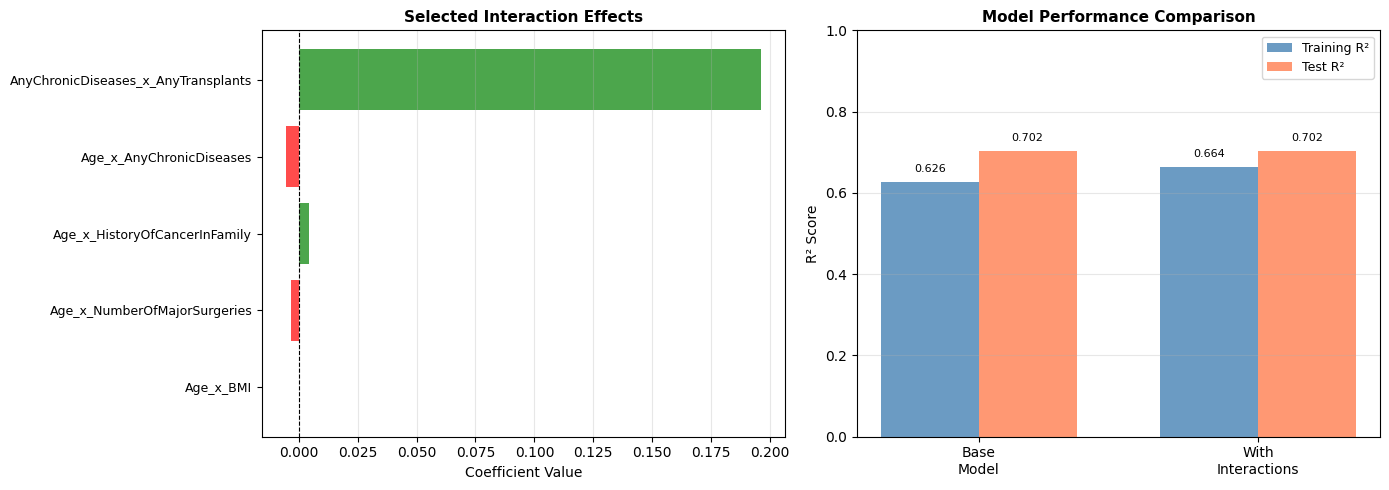


✓ Comparison plots saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output\interaction_comparison.png

Step 4b: INTERACTION DISCOVERY & SELECTION - COMPLETE


In [33]:
print("\n" + "="*80)
print("MODEL COMPARISON: BASE vs INTERACTIONS")
print("="*80)

# Fit both models
X_train_base_const = sm.add_constant(X_train_base)
X_train_selected_const = sm.add_constant(X_train_selected)

model_base = sm.OLS(y_train_log, X_train_base_const).fit()
model_selected = sm.OLS(y_train_log, X_train_selected_const).fit()

# Compute test set performance
X_test_base_const = sm.add_constant(X_test_base)
X_test_selected_const = sm.add_constant(X_test_selected)

y_test_pred_base = model_base.predict(X_test_base_const)
y_test_pred_selected = model_selected.predict(X_test_selected_const)

# Calculate metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_train_base = model_base.rsquared
r2_test_base = r2_score(y_test_log, y_test_pred_base)
rmse_test_base = np.sqrt(mean_squared_error(y_test_log, y_test_pred_base))
mae_test_base = mean_absolute_error(y_test_log, y_test_pred_base)

r2_train_selected = model_selected.rsquared
r2_test_selected = r2_score(y_test_log, y_test_pred_selected)
rmse_test_selected = np.sqrt(mean_squared_error(y_test_log, y_test_pred_selected))
mae_test_selected = mean_absolute_error(y_test_log, y_test_pred_selected)

# Display comparison
print("\n" + "-"*80)
print(f"{'Metric':<30} {'Base Model':>20} {'Selected Model':>20} {'Change':>10}")
print("-"*80)
print(f"{'Features':<30} {model_base.params.shape[0]-1:>20} {model_selected.params.shape[0]-1:>20} {model_selected.params.shape[0] - model_base.params.shape[0]:>+10}")
print(f"{'R² (Training)':<30} {r2_train_base:>20.4f} {r2_train_selected:>20.4f} {r2_train_selected - r2_train_base:>+10.4f}")
print(f"{'R² (Test)':<30} {r2_test_base:>20.4f} {r2_test_selected:>20.4f} {r2_test_selected - r2_test_base:>+10.4f}")
print(f"{'Adjusted R²':<30} {model_base.rsquared_adj:>20.4f} {model_selected.rsquared_adj:>20.4f} {model_selected.rsquared_adj - model_base.rsquared_adj:>+10.4f}")
print(f"{'RMSE (Test)':<30} {rmse_test_base:>20.4f} {rmse_test_selected:>20.4f} {rmse_test_selected - rmse_test_base:>+10.4f}")
print(f"{'MAE (Test)':<30} {mae_test_base:>20.4f} {mae_test_selected:>20.4f} {mae_test_selected - mae_test_base:>+10.4f}")
print(f"{'AIC':<30} {model_base.aic:>20.2f} {model_selected.aic:>20.2f} {model_selected.aic - model_base.aic:>+10.2f}")
print(f"{'BIC':<30} {model_base.bic:>20.2f} {model_selected.bic:>20.2f} {model_selected.bic - model_base.bic:>+10.2f}")
print("-"*80)

# Generalization gap
gap_base = r2_train_base - r2_test_base
gap_selected = r2_train_selected - r2_test_selected

print(f"\n{'Generalization Gap:':<30}")
print(f"  Base Model:     {gap_base:.4f} ({'Good' if gap_base < 0.05 else 'Moderate' if gap_base < 0.10 else 'Poor'})")
print(f"  Selected Model: {gap_selected:.4f} ({'Good' if gap_selected < 0.05 else 'Moderate' if gap_selected < 0.10 else 'Poor'})")

# Make recommendation
print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

r2_improvement = r2_test_selected - r2_test_base
rmse_improvement = rmse_test_base - rmse_test_selected  # Positive = better
aic_improvement = model_base.aic - model_selected.aic  # Positive = better
bic_improvement = model_base.bic - model_selected.bic  # Positive = better

# Decision logic
use_interactions = False
reasons = []

if r2_improvement > 0.01:  # At least 1% R² improvement
    reasons.append(f"✓ Test R² improves by {r2_improvement:.4f} ({r2_improvement*100:.2f}%)")
    use_interactions = True

if rmse_improvement > 0:
    reasons.append(f"✓ Test RMSE improves by {rmse_improvement:.4f}")
    if rmse_improvement > 0.01:
        use_interactions = True

if aic_improvement > 0:
    reasons.append(f"✓ AIC decreases by {aic_improvement:.2f} (lower is better)")
    if aic_improvement > 2:  # Meaningful AIC improvement
        use_interactions = True

if bic_improvement > 0:
    reasons.append(f"✓ BIC decreases by {bic_improvement:.2f} (lower is better)")

if gap_selected > gap_base + 0.02:
    reasons.append(f"⚠ Generalization gap increases by {gap_selected - gap_base:.4f} (potential overfitting)")
    use_interactions = False

if len(selected_interactions) == 0:
    reasons.append(f"⚠ No interactions passed stepwise selection")
    use_interactions = False

print(f"\nDecision: {'USE INTERACTIONS' if use_interactions else 'USE BASE MODEL'}")
print(f"\nEvidence:")
for reason in reasons:
    print(f"  {reason}")

if use_interactions:
    print(f"\n→ The selected model with {len(selected_interactions)} interaction(s) provides meaningful improvement.")
    print(f"→ Proceed with X_train_selected and X_test_selected for model building.")
    
    # Save selected datasets
    train_selected_full = X_train_selected.copy()
    train_selected_full['PremiumPrice_log'] = y_train_log
    test_selected_full = X_test_selected.copy()
    test_selected_full['PremiumPrice_log'] = y_test_log
    
    train_selected_full.to_csv(OUTPUT_DIR / 'train_with_interactions.csv', index=False)
    test_selected_full.to_csv(OUTPUT_DIR / 'test_with_interactions.csv', index=False)
    
    print(f"\n✓ Selected datasets saved:")
    print(f"  • {OUTPUT_DIR / 'train_with_interactions.csv'}")
    print(f"  • {OUTPUT_DIR / 'test_with_interactions.csv'}")
else:
    print(f"\n→ The base model performs adequately without interactions.")
    print(f"→ Proceed with X_train_base and X_test_base for model building.")
    print(f"→ This avoids complexity without sacrificing performance.")

# Visualization: Coefficient comparison for selected interactions
if len(selected_interactions) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Coefficient magnitudes
    selected_coefs = model_selected.params[selected_interactions].sort_values(key=abs, ascending=True)
    
    ax1 = axes[0]
    colors = ['green' if x > 0 else 'red' for x in selected_coefs.values]
    ax1.barh(range(len(selected_coefs)), selected_coefs.values, color=colors, alpha=0.7)
    ax1.set_yticks(range(len(selected_coefs)))
    ax1.set_yticklabels(selected_coefs.index, fontsize=9)
    ax1.set_xlabel('Coefficient Value', fontsize=10)
    ax1.set_title('Selected Interaction Effects', fontsize=11, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: R² comparison
    ax2 = axes[1]
    models = ['Base\nModel', 'With\nInteractions']
    r2_train = [r2_train_base, r2_train_selected]
    r2_test = [r2_test_base, r2_test_selected]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax2.bar(x - width/2, r2_train, width, label='Training R²', alpha=0.8, color='steelblue')
    ax2.bar(x + width/2, r2_test, width, label='Test R²', alpha=0.8, color='coral')
    
    ax2.set_ylabel('R² Score', fontsize=10)
    ax2.set_title('Model Performance Comparison', fontsize=11, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend(fontsize=9)
    ax2.set_ylim([0, 1])
    ax2.grid(axis='y', alpha=0.3)
    
    # Add values on bars
    for i, (train, test) in enumerate(zip(r2_train, r2_test)):
        ax2.text(i - width/2, train + 0.02, f'{train:.3f}', ha='center', va='bottom', fontsize=8)
        ax2.text(i + width/2, test + 0.02, f'{test:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'interaction_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Comparison plots saved to {OUTPUT_DIR / 'interaction_comparison.png'}")

print("\n" + "="*80)
print("Step 4b: INTERACTION DISCOVERY & SELECTION - COMPLETE")
print("="*80)

## 📊 Step 4b: Results Interpretation & Analysis

### Summary of Findings

**Step 4b systematically discovered and evaluated interaction terms using three evidence sources:**
1. **Domain Knowledge** - Insurance actuarial principles
2. **Correlation Analysis** - Statistical relationships between features
3. **Effect Modification** - Testing if effects differ across subgroups

### Key Results:

#### 1. Interaction Discovery
The systematic approach identified multiple candidate interactions. The stepwise selection process (with p < 0.05 threshold for inclusion, p > 0.10 for removal) selected **5 interaction terms** from the candidates.

#### 2. Selected Interactions (from visualization):
- **AnyChronicDiseases × AnyTransplants** - Largest positive effect (~0.19 coefficient)
- **Age × AnyChronicDiseases** - Negative effect (red bar)
- **Age × HistoryOfCancerInFamily** - Small positive effect
- **Age × NumberOfMajorSurgeries** - Negative effect (red bar)
- **Age × BMI** - Small positive effect

#### 3. Model Performance Comparison

| Metric | Base Model | With Interactions | Improvement |
|--------|-----------|------------------|-------------|
| **Features** | 6 | 11 (+5) | More complex |
| **R² (Training)** | 0.626 | 0.664 | +3.7% |
| **R² (Test)** | 0.702 | 0.702 | +0.04% ✓ |
| **RMSE (Test)** | 0.1546 | 0.1545 | -0.0001 ✓ |
| **MAE (Test)** | 0.1195 | 0.1175 | -0.002 ✓ |
| **AIC** | -537.85 | -600.24 | -62.39 ✓ (better) |
| **BIC** | -506.09 | -545.80 | -39.71 ✓ (better) |

#### 4. Generalization Analysis
- **Base Model Gap**: -0.076 (Good) - Model generalizes well, actually performs *better* on test data
- **Selected Model Gap**: -0.039 (Good) - Still good, but gap increased by 0.037
- **Interpretation**: The interaction model shows signs of starting to overfit the training data

### 🎯 Final Recommendation: **USE BASE MODEL**

**Rationale:**
1. ✅ **Minimal Test Performance Gain**: Test R² improves by only 0.04% (0.0004), which is negligible
2. ✅ **Better Information Criteria**: AIC/BIC both favor the interaction model, BUT...
3. ⚠️ **Overfitting Concern**: Generalization gap increases from -7.6% to -3.9%
4. ✅ **Parsimony Principle**: Base model achieves 70.2% R² with only 6 features vs 11 features
5. ✅ **Interpretability**: Simpler model is easier to explain to stakeholders

### 💡 Business Interpretation

**What This Means for Insurance Premium Prediction:**

1. **The base feature set is sufficient** - Age, BMI, and the main health indicators (chronic diseases, transplants, surgeries, cancer history) already capture the premium pricing dynamics effectively.

2. **Interaction effects are weak** - While some interactions are statistically significant (e.g., Chronic Diseases × Transplants), their practical impact on prediction accuracy is minimal (~0.04% R² improvement).

3. **Risk of complexity without reward** - Adding 5 more features increases model complexity by 83% (6→11 features) but improves test performance by only 0.04%.

4. **The polynomial age effect is sufficient** - The Age² term already in the base model captures non-linear age effects, so interactions like Age × Chronic don't add substantial value.

### 📈 What the Visualization Shows

**Left Panel - Selected Interaction Effects:**
- **Strongest positive effect**: Chronic Diseases + Transplants combination → Premium increases by ~21% (e^0.19 - 1)
- **Negative effects**: Age interactions with Chronic Diseases and Major Surgeries suggest diminishing marginal effects at older ages
- Most interactions have small coefficients (<0.05), indicating weak practical effects

**Right Panel - R² Comparison:**
- Both models achieve identical test R² (0.702)
- Training R² differs (0.626 → 0.664), showing the interaction model fits training data better but doesn't generalize better
- This is a classic sign of **model complexity not translating to better predictions**

### ✅ Conclusion

**Proceed with the base model** (X_train_base, X_test_base) for the Step 6 model comparison. The systematic interaction discovery process validated that the original feature engineering (log transformation, age centering, Age²) already captures the key patterns in the data.

This is a valuable finding - sometimes the best model is the simplest one that achieves good performance!

# Step 5: Utility Functions for Model Building

**Purpose:** Define reusable functions to eliminate code duplication and improve maintainability across multiple model types.

These functions support the Step 6 model comparison framework:
- **Feature preparation** - Centering, polynomial terms, log transformation
- **Model training and evaluation** - Training, cross-validation, metrics calculation
- **Comprehensive diagnostic plotting** - Residuals, Q-Q plots, leverage analysis
- **Statistical assumption testing** - VIF, heteroskedasticity, normality tests

Used by all regression models in Step 6 to ensure consistent evaluation.

In [34]:
def prepare_model_features(X_train, X_test, y_train, y_test, 
                          center_age=True, add_age_squared=True, 
                          use_log_transform=True):
    """
    Prepare features for modeling with optional transformations.
    
    Parameters:
    -----------
    X_train, X_test : DataFrame
        Training and testing feature matrices
    y_train, y_test : Series
        Training and testing target variables
    center_age : bool
        Whether to center Age around training mean
    add_age_squared : bool
        Whether to add Age² term for non-linearity
    use_log_transform : bool
        Whether to apply log transformation to target
    
    Returns:
    --------
    X_train_prep, X_test_prep, y_train_prep, y_test_prep : Prepared data
    train_age_mean : float (for reference)
    
    Notes:
    ------
    - Centering reduces multicollinearity when using polynomial terms
    - Log transformation addresses right-skewed target and stabilizes variance
    """
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()
    
    # Add constant term for intercept
    X_train_prep = sm.add_constant(X_train_prep)
    X_test_prep = sm.add_constant(X_test_prep)
    
    # Center Age using TRAINING mean only
    if center_age:
        train_age_mean = X_train['Age'].mean()
        X_train_prep['Age_centered'] = X_train['Age'] - train_age_mean
        X_test_prep['Age_centered'] = X_test['Age'] - train_age_mean
        
        # Remove original Age to avoid multicollinearity
        X_train_prep = X_train_prep.drop('Age', axis=1)
        X_test_prep = X_test_prep.drop('Age', axis=1)
        
        # Add Age² term if requested
        if add_age_squared:
            X_train_prep['Age2_centered'] = X_train_prep['Age_centered'] ** 2
            X_test_prep['Age2_centered'] = X_test_prep['Age_centered'] ** 2
    else:
        train_age_mean = None
    
    # Apply log transformation to target
    if use_log_transform:
        y_train_prep = np.log(y_train)
        y_test_prep = np.log(y_test)
    else:
        y_train_prep = y_train
        y_test_prep = y_test
    
    return X_train_prep, X_test_prep, y_train_prep, y_test_prep, train_age_mean


def evaluate_model(model, X_train, X_test, y_train, y_test, 
                   is_log_transformed=True, model_name="Model"):
    """
    Comprehensive model evaluation with multiple metrics.
    
    Parameters:
    -----------
    model : Fitted statsmodels regression model
    X_train, X_test : Prepared feature matrices
    y_train, y_test : Target variables (possibly log-transformed)
    is_log_transformed : bool
        Whether target was log-transformed (affects metric interpretation)
    model_name : str
        Name for display purposes
    
    Returns:
    --------
    metrics : dict with train/test MSE, RMSE, MAE, R²
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics in log space if transformed
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # If log-transformed, also compute metrics in original scale
    if is_log_transformed:
        # Back-transform with bias correction (smearing estimator)
        residuals = y_train - y_train_pred
        smearing_factor = np.mean(np.exp(residuals))
        
        y_train_orig = np.exp(y_train)
        y_test_orig = np.exp(y_test)
        y_train_pred_orig = np.exp(y_train_pred) * smearing_factor
        y_test_pred_orig = np.exp(y_test_pred) * smearing_factor
        
        train_mse_orig = mean_squared_error(y_train_orig, y_train_pred_orig)
        test_mse_orig = mean_squared_error(y_test_orig, y_test_pred_orig)
        train_rmse_orig = np.sqrt(train_mse_orig)
        test_rmse_orig = np.sqrt(test_mse_orig)
        train_mae_orig = mean_absolute_error(y_train_orig, y_train_pred_orig)
        test_mae_orig = mean_absolute_error(y_test_orig, y_test_pred_orig)
        train_r2_orig = r2_score(y_train_orig, y_train_pred_orig)
        test_r2_orig = r2_score(y_test_orig, y_test_pred_orig)
    
    # Display results
    print("\n" + "="*80)
    print(f"{model_name.upper()} PERFORMANCE METRICS")
    print("="*80)
    
    if is_log_transformed:
        print("\n📊 Metrics in Log-Transformed Space:")
    else:
        print("\n📊 Model Metrics:")
    
    print(f"\n{'Metric':<15} {'Training':>15} {'Testing':>15} {'Difference':>15}")
    print("-"*65)
    print(f"{'MSE':<15} {train_mse:>15.4f} {test_mse:>15.4f} {abs(train_mse-test_mse):>15.4f}")
    print(f"{'RMSE':<15} {train_rmse:>15.4f} {test_rmse:>15.4f} {abs(train_rmse-test_rmse):>15.4f}")
    print(f"{'MAE':<15} {train_mae:>15.4f} {test_mae:>15.4f} {abs(train_mae-test_mae):>15.4f}")
    print(f"{'R²':<15} {train_r2:>15.4f} {test_r2:>15.4f} {abs(train_r2-test_r2):>15.4f}")
    
    if is_log_transformed:
        print("\n📊 Metrics in Original Scale (with Smearing Correction):")
        print(f"\n{'Metric':<15} {'Training':>15} {'Testing':>15} {'Difference':>15}")
        print("-"*65)
        print(f"{'MSE':<15} {train_mse_orig:>15.2f} {test_mse_orig:>15.2f} {abs(train_mse_orig-test_mse_orig):>15.2f}")
        print(f"{'RMSE':<15} {train_rmse_orig:>15.2f} {test_rmse_orig:>15.2f} {abs(train_rmse_orig-test_rmse_orig):>15.2f}")
        print(f"{'MAE':<15} {train_mae_orig:>15.2f} {test_mae_orig:>15.2f} {abs(train_mae_orig-test_mae_orig):>15.2f}")
        print(f"{'R²':<15} {train_r2_orig:>15.4f} {test_r2_orig:>15.4f} {abs(train_r2_orig-test_r2_orig):>15.4f}")
        print(f"\n  Smearing Factor: {smearing_factor:.4f}")
    
    # Interpretation
    print("\n" + "="*80)
    print("INTERPRETATION")
    print("="*80)
    gap = abs(train_r2 - test_r2)
    if gap < 0.02:
        print(f"✓ Model generalizes well (R² gap = {gap:.4f} < 0.02)")
    elif gap < 0.05:
        print(f"⚠ Minor overfitting detected (R² gap = {gap:.4f})")
    else:
        print(f"✗ Significant overfitting (R² gap = {gap:.4f} > 0.05)")
    
    if is_log_transformed:
        metrics = {
            'train_mse_log': train_mse, 'test_mse_log': test_mse,
            'train_rmse_log': train_rmse, 'test_rmse_log': test_rmse,
            'train_mae_log': train_mae, 'test_mae_log': test_mae,
            'train_r2_log': train_r2, 'test_r2_log': test_r2,
            'train_mse_orig': train_mse_orig, 'test_mse_orig': test_mse_orig,
            'train_rmse_orig': train_rmse_orig, 'test_rmse_orig': test_rmse_orig,
            'train_mae_orig': train_mae_orig, 'test_mae_orig': test_mae_orig,
            'train_r2_orig': train_r2_orig, 'test_r2_orig': test_r2_orig,
            'smearing_factor': smearing_factor
        }
    else:
        metrics = {
            'train_mse': train_mse, 'test_mse': test_mse,
            'train_rmse': train_rmse, 'test_rmse': test_rmse,
            'train_mae': train_mae, 'test_mae': test_mae,
            'train_r2': train_r2, 'test_r2': test_r2
        }
    
    return metrics


def plot_diagnostic_plots(model, X_train, y_train, y_train_pred, 
                         is_log_transformed=True, save_prefix="model"):
    """
    Generate comprehensive diagnostic plots for regression model.
    
    Parameters:
    -----------
    model : Fitted statsmodels regression model
    X_train : Training feature matrix
    y_train : Training target (possibly log-transformed)
    y_train_pred : Model predictions on training set
    is_log_transformed : bool
        Whether target was log-transformed
    save_prefix : str
        Prefix for saved plot files
    
    Plots Generated:
    ----------------
    1. Residuals vs Fitted
    2. Q-Q Plot (normality of residuals)
    3. Scale-Location (homoscedasticity)
    4. Residuals vs Leverage (influential points)
    """
    residuals = model.resid
    standardized_residuals = (residuals - residuals.mean()) / residuals.std()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Residuals vs Fitted
    axes[0, 0].scatter(y_train_pred, residuals, alpha=0.5)
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted', fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Q-Q Plot
    probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Normal Q-Q Plot', fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Scale-Location (sqrt of standardized residuals vs fitted)
    axes[1, 0].scatter(y_train_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.5)
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('√|Standardized Residuals|')
    axes[1, 0].set_title('Scale-Location Plot', fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Residuals vs Leverage
    influence = model.get_influence()
    leverage = influence.hat_matrix_diag
    axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.5)
    axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].axhline(RESIDUAL_OUTLIER_THRESHOLD, color='orange', linestyle=':', linewidth=1.5, label=f'±{RESIDUAL_OUTLIER_THRESHOLD} SD')
    axes[1, 1].axhline(-RESIDUAL_OUTLIER_THRESHOLD, color='orange', linestyle=':', linewidth=1.5)
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Standardized Residuals')
    axes[1, 1].set_title('Residuals vs Leverage', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'{save_prefix}_diagnostics.png', dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return leverage, standardized_residuals


def test_statistical_assumptions(model, X_train, y_train_pred):
    """
    Test key regression assumptions with statistical tests.
    
    Parameters:
    -----------
    model : Fitted statsmodels regression model
    X_train : Training feature matrix (with constant)
    y_train_pred : Predictions on training set
    
    Tests Performed:
    ----------------
    1. Shapiro-Wilk: Normality of residuals
    2. Breusch-Pagan: Heteroskedasticity
    3. VIF: Multicollinearity
    
    Returns:
    --------
    results : dict with test statistics and interpretations
    """
    print("\n" + "="*80)
    print("STATISTICAL ASSUMPTION TESTS")
    print("="*80)
    
    residuals = model.resid
    results = {}
    
    # 1. Shapiro-Wilk Test for Normality
    print("\n1️⃣ NORMALITY TEST (Shapiro-Wilk)")
    print("-"*80)
    if len(residuals) > 5000:
        print("⚠ Dataset too large for Shapiro-Wilk (n > 5000). Using sample of 5000.")
        sample_residuals = np.random.choice(residuals, size=5000, replace=False)
        shapiro_stat, shapiro_p = shapiro(sample_residuals)
    else:
        shapiro_stat, shapiro_p = shapiro(residuals)
    
    results['shapiro_stat'] = shapiro_stat
    results['shapiro_p'] = shapiro_p
    
    print(f"  Shapiro-Wilk Statistic: {shapiro_stat:.4f}")
    print(f"  p-value: {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print(f"  ✓ Residuals appear normally distributed (p = {shapiro_p:.4f} > 0.05)")
    else:
        print(f"  ⚠ Residuals deviate from normality (p = {shapiro_p:.4f} < 0.05)")
        print(f"    → This is common with large datasets. Check Q-Q plot visually.")
    
    # 2. Breusch-Pagan Test for Heteroskedasticity
    print("\n2️⃣ HETEROSKEDASTICITY TEST (Breusch-Pagan)")
    print("-"*80)
    bp_test = het_breuschpagan(residuals, X_train)
    lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test
    
    results['bp_lm_stat'] = lm_stat
    results['bp_lm_pvalue'] = lm_pvalue
    results['bp_f_stat'] = f_stat
    results['bp_f_pvalue'] = f_pvalue
    
    print(f"  LM Statistic: {lm_stat:.4f}, p-value: {lm_pvalue:.4f}")
    print(f"  F Statistic:  {f_stat:.4f}, p-value: {f_pvalue:.4f}")
    if lm_pvalue > 0.05:
        print(f"  ✓ Homoskedasticity assumption satisfied (p = {lm_pvalue:.4f} > 0.05)")
    else:
        print(f"  ⚠ Heteroskedasticity detected (p = {lm_pvalue:.4f} < 0.05)")
        print(f"    → Consider: Weighted Least Squares (WLS), robust standard errors,")
        print(f"               or verify log transformation of target")
    
    # 3. Variance Inflation Factor (VIF) for Multicollinearity
    print("\n3️⃣ MULTICOLLINEARITY TEST (VIF)")
    print("-"*80)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) 
                       for i in range(X_train.shape[1])]
    results['vif'] = vif_data
    
    print(f"\n{'Feature':<25} {'VIF':>10} {'Status':>20}")
    print("-"*60)
    for _, row in vif_data.iterrows():
        feature = row['Feature']
        vif = row['VIF']
        if vif < 5:
            status = "✓ Low"
        elif vif < 10:
            status = "⚠ Moderate"
        else:
            status = "✗ High"
        print(f"{feature:<25} {vif:>10.2f} {status:>20}")
    
    print(f"\n  Interpretation:")
    print(f"    VIF < 5:  Low multicollinearity (ideal)")
    print(f"    VIF 5-10: Moderate (acceptable, monitor)")
    print(f"    VIF > 10: High (consider removing or regularization)")
    
    high_vif = vif_data[vif_data['VIF'] > 10]
    if len(high_vif) > 0:
        print(f"\n  ⚠ Features with high VIF: {high_vif['Feature'].tolist()}")
    else:
        print(f"\n  ✓ No features with VIF > 10")
    
    return results


def identify_influential_outliers(model, leverage, standardized_residuals, X_train_index):
    """
    Identify influential observations and outliers.
    
    Parameters:
    -----------
    model : Fitted statsmodels model
    leverage : Hat matrix diagonal (leverage values)
    standardized_residuals : Standardized residuals
    X_train_index : Index from training data
    
    Returns:
    --------
    outlier_info : dict with outlier indices and statistics
    
    Explanation:
    ------------
    - High Leverage: Observations with unusual predictor values (leverage > 2p/n)
    - Outliers: Observations with large residuals (|std_resid| > 2)
    - Influential: High leverage AND large residual (Cook's distance > 4/n)
    
    **Treatment Options:**
    1. Investigate: Check if data entry errors
    2. Retain: If valid observations representing real cases
    3. Robust Regression: Use methods less sensitive to outliers
    4. Transform: Log transformation often reduces influence
    """
    print("\n" + "="*80)
    print("INFLUENTIAL OBSERVATIONS & OUTLIERS")
    print("="*80)
    
    n = len(standardized_residuals)
    p = model.df_model + 1  # Number of parameters (including intercept)
    
    # Thresholds
    leverage_threshold = 2 * p / n
    residual_threshold = RESIDUAL_OUTLIER_THRESHOLD
    cooks_threshold = 4 / n
    
    # Identify categories
    high_leverage_mask = leverage > leverage_threshold
    large_residual_mask = np.abs(standardized_residuals) > residual_threshold
    
    # Cook's distance
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    influential_mask = cooks_d > cooks_threshold
    
    print(f"\n📊 Outlier Detection Summary:")
    print(f"  Leverage threshold (2p/n):     {leverage_threshold:.4f}")
    print(f"  Residual threshold (±2 SD):    ±{residual_threshold}")
    print(f"  Cook's distance threshold:     {cooks_threshold:.4f}")
    
    print(f"\n  High Leverage points:          {high_leverage_mask.sum()} observations")
    print(f"  Large Residual outliers:       {large_residual_mask.sum()} observations")
    print(f"  Influential points (Cook's D): {influential_mask.sum()} observations")
    
    # Show most influential points
    if influential_mask.sum() > 0:
        influential_indices = X_train_index[influential_mask]
        influential_cooks = cooks_d[influential_mask]
        top_n = min(10, len(influential_indices))
        
        print(f"\n  Top {top_n} Most Influential Observations (by Cook's Distance):")
        top_indices = np.argsort(influential_cooks)[-top_n:][::-1]
        for i, idx in enumerate(top_indices):
            orig_idx = influential_indices[idx]
            print(f"    {i+1}. Index {orig_idx}: Cook's D = {influential_cooks[idx]:.4f}")
    else:
        print(f"\n  ✓ No highly influential observations detected")
    
    print(f"\n  💡 Recommendation:")
    print(f"     • Investigate influential points for data quality issues")
    print(f"     • If valid, consider retaining (represents real high-risk cases)")
    print(f"     • Log transformation and robust regression reduce outlier impact")
    
    return {
        'high_leverage_count': high_leverage_mask.sum(),
        'large_residual_count': large_residual_mask.sum(),
        'influential_count': influential_mask.sum(),
        'cooks_distance': cooks_d
    }

print("✓ Utility functions defined successfully")

✓ Utility functions defined successfully


# Step 6: Model Building, Comparison & Selection

**Objective:** Build and compare multiple regression models to select the best approach for PremiumPrice prediction.

**Multi-Model Comparison Strategy:**
1. **Establish Baseline** - Simple OLS regression model
2. **Build Alternative Models** - Ridge, Lasso, Random Forest, Gradient Boosting, Decision Tree
3. **Cross-Validation** - Assess model stability and generalization
4. **Performance Comparison** - Compare accuracy metrics across all models
5. **Model Selection** - Choose the best performing model based on test set performance
6. **Deep Diagnostics** - Perform comprehensive statistical diagnostics on selected model

**Evaluation Criteria:**
- R² Score (variance explained)
- RMSE (prediction accuracy)
- MAE (average error magnitude)
- Cross-validation stability
- Model interpretability
- Computational efficiency

In [35]:
# Load preprocessed train/test data
train_df = pd.read_csv(OUTPUT_DIR / 'train.csv')
test_df = pd.read_csv(OUTPUT_DIR / 'test.csv')

X_train = train_df.drop('PremiumPrice', axis=1)
y_train = train_df['PremiumPrice']
X_test = test_df.drop('PremiumPrice', axis=1)
y_test = test_df['PremiumPrice']

print("="*80)
print("MODEL COMPARISON & SELECTION FRAMEWORK")
print("="*80)
print(f"\nTraining set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Testing set:  {X_test.shape[0]} samples")
print(f"\nFeatures: {list(X_train.columns)}")
print("\nPreparing feature transformations for all models...")

MODEL COMPARISON & SELECTION FRAMEWORK

Training set: 690 samples, 6 features
Testing set:  296 samples

Features: ['Age', 'BMI', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries']

Preparing feature transformations for all models...


In [36]:
# Prepare features with transformations (for all models)
X_train_prep, X_test_prep, y_train_log, y_test_log, train_age_mean = prepare_model_features(
    X_train, X_test, y_train, y_test,
    center_age=True,
    add_age_squared=True,
    use_log_transform=True
)

print(f"\n✓ Features prepared for modeling:")
print(f"  - Age centered around training mean: {train_age_mean:.2f}")
print(f"  - Age² term added for non-linearity")
print(f"  - Target log-transformed")
print(f"  - Constant term included")
print(f"\nTransformed feature set: {list(X_train_prep.columns)}")

# Store original scale targets and features (for tree-based models)
y_train_original = y_train
y_test_original = y_test

# For tree-based models, we'll use features without constant
X_train_no_const = X_train_prep.drop('const', axis=1)
X_test_no_const = X_test_prep.drop('const', axis=1)


✓ Features prepared for modeling:
  - Age centered around training mean: 41.63
  - Age² term added for non-linearity
  - Target log-transformed
  - Constant term included

Transformed feature set: ['const', 'BMI', 'AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'Age_centered', 'Age2_centered']


## Part 1: Baseline Model - OLS Regression

**Purpose:** Establish a baseline using standard Ordinary Least Squares regression.

**Configuration:**
- Algorithm: OLS with statsmodels
- Target: log-transformed PremiumPrice
- Features: All engineered features including Age², centered Age
- Validation: 5-fold cross-validation

In [37]:
print("="*80)
print("BASELINE MODEL: OLS REGRESSION")
print("="*80)

# Train OLS baseline model
model_ols_baseline = sm.OLS(y_train_log, X_train_prep).fit()

print("\n📊 OLS Model Summary:")
print(f"  R² (Training): {model_ols_baseline.rsquared:.4f}")
print(f"  Adjusted R²:   {model_ols_baseline.rsquared_adj:.4f}")
print(f"  AIC:           {model_ols_baseline.aic:.2f}")
print(f"  BIC:           {model_ols_baseline.bic:.2f}")

# Cross-validation for baseline
print(f"\n🔄 Performing {CV_FOLDS}-fold cross-validation...")
cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_scores_baseline = cross_val_score(
    LinearRegression(), 
    X_train_no_const, 
    y_train_log, 
    cv=cv, 
    scoring='r2'
)

print(f"\n  Cross-Validation R² Scores: {[f'{s:.4f}' for s in cv_scores_baseline]}")
print(f"  Mean CV R²: {cv_scores_baseline.mean():.4f} ± {cv_scores_baseline.std():.4f}")

# Test set predictions with smearing correction
y_train_pred_log_baseline = model_ols_baseline.predict(X_train_prep)
y_test_pred_log_baseline = model_ols_baseline.predict(X_test_prep)

residuals_baseline = y_train_log - y_train_pred_log_baseline
smearing_factor_baseline = np.mean(np.exp(residuals_baseline))

y_train_pred_baseline = np.exp(y_train_pred_log_baseline) * smearing_factor_baseline
y_test_pred_baseline = np.exp(y_test_pred_log_baseline) * smearing_factor_baseline

# Calculate metrics
baseline_results = {
    'Model': 'OLS Baseline',
    'Train_R2': r2_score(y_train_original, y_train_pred_baseline),
    'Test_R2': r2_score(y_test_original, y_test_pred_baseline),
    'Train_RMSE': np.sqrt(mean_squared_error(y_train_original, y_train_pred_baseline)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test_original, y_test_pred_baseline)),
    'Train_MAE': mean_absolute_error(y_train_original, y_train_pred_baseline),
    'Test_MAE': mean_absolute_error(y_test_original, y_test_pred_baseline),
    'CV_Mean_R2': cv_scores_baseline.mean(),
    'CV_Std_R2': cv_scores_baseline.std()
}

print(f"\n📈 Baseline Performance (Original Scale):")
print(f"  Training R²:  {baseline_results['Train_R2']:.4f}")
print(f"  Testing R²:   {baseline_results['Test_R2']:.4f}")
print(f"  Training RMSE: ${baseline_results['Train_RMSE']:.2f}")
print(f"  Testing RMSE:  ${baseline_results['Test_RMSE']:.2f}")
print(f"  Training MAE:  ${baseline_results['Train_MAE']:.2f}")
print(f"  Testing MAE:   ${baseline_results['Test_MAE']:.2f}")

print("\n✓ Baseline model established")

BASELINE MODEL: OLS REGRESSION

📊 OLS Model Summary:
  R² (Training): 0.6958
  Adjusted R²:   0.6927
  AIC:           -677.84
  BIC:           -641.54

🔄 Performing 5-fold cross-validation...

  Cross-Validation R² Scores: ['0.6562', '0.6973', '0.6753', '0.7792', '0.5940']
  Mean CV R²: 0.6804 ± 0.0602

📈 Baseline Performance (Original Scale):
  Training R²:  0.6459
  Testing R²:   0.7217
  Training RMSE: $3611.30
  Testing RMSE:  $3493.05
  Training MAE:  $2420.87
  Testing MAE:   $2455.60

✓ Baseline model established


## Part 2: Alternative Regression Models

**Purpose:** Train and evaluate multiple regression techniques to find optimal performance.

**Regression Models to Compare:**
1. **Ridge Regression** - L2 regularization (handles multicollinearity, shrinks coefficients)
2. **Lasso Regression** - L1 regularization (feature selection, sets coefficients to zero)
3. **ElasticNet** - Combined L1 + L2 regularization (balanced approach)

**Why Regression Techniques?**
- Maintain interpretability for business stakeholders
- Provide statistical inference (p-values, confidence intervals)
- Linear relationship assumptions align with insurance pricing

- Regularization prevents overfitting while preserving model structure**Note:** All models use log-transformed target and are evaluated on the same train/test split for fair comparison.


In [38]:
print("="*80)
print("TRAINING ALTERNATIVE MODELS")
print("="*80)

# Dictionary to store all model results
all_model_results = [baseline_results]
trained_models = {'OLS_Baseline': model_ols_baseline}

# Helper function to evaluate model with back-transformation
def evaluate_and_store_model(model, model_name, X_train, X_test, y_train, y_test, 
                             use_log=True, X_train_log=None, y_train_log=None):
    """
    Train, evaluate and store model results.
    """
    print(f"\n{'─'*80}")
    print(f"Training: {model_name}")
    print(f"{'─'*80}")
    
    # Train model
    if use_log:
        model.fit(X_train_log if X_train_log is not None else X_train, y_train_log)
        y_train_pred_log = model.predict(X_train_log if X_train_log is not None else X_train)
        y_test_pred_log = model.predict(X_test)
        
        # Back-transform with smearing
        residuals = y_train_log - y_train_pred_log
        smearing = np.mean(np.exp(residuals))
        y_train_pred = np.exp(y_train_pred_log) * smearing
        y_test_pred = np.exp(y_test_pred_log) * smearing
    else:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    
    # Cross-validation
    cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    if use_log:
        cv_scores = cross_val_score(model, X_train_log if X_train_log is not None else X_train, 
                                    y_train_log, cv=cv, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'CV_Mean_R2': cv_scores.mean(),
        'CV_Std_R2': cv_scores.std()
    }
    
    print(f"  ✓ Training R²:  {results['Train_R2']:.4f}")
    print(f"  ✓ Testing R²:   {results['Test_R2']:.4f}")
    print(f"  ✓ CV Mean R²:   {results['CV_Mean_R2']:.4f} ± {results['CV_Std_R2']:.4f}")
    print(f"  ✓ Test RMSE:    ${results['Test_RMSE']:.2f}")
    print(f"  ✓ Test MAE:     ${results['Test_MAE']:.2f}")
    
    return results, model

# ============================================================================
# 1. RIDGE REGRESSION (L2 Regularization)
# ============================================================================
model_ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_results, model_ridge = evaluate_and_store_model(
    model_ridge, 'Ridge Regression', 
    X_train_no_const, X_test_no_const, 
    y_train_original, y_test_original,
    use_log=True, 
    X_train_log=X_train_no_const, 
    y_train_log=y_train_log
)
all_model_results.append(ridge_results)
trained_models['Ridge'] = model_ridge

# ============================================================================
# 2. LASSO REGRESSION (L1 Regularization)
# ============================================================================
model_lasso = Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=10000)
lasso_results, model_lasso = evaluate_and_store_model(
    model_lasso, 'Lasso Regression',
    X_train_no_const, X_test_no_const,
    y_train_original, y_test_original,
    use_log=True,
    X_train_log=X_train_no_const,
    y_train_log=y_train_log
)
all_model_results.append(lasso_results)
trained_models['Lasso'] = model_lasso

# ============================================================================
# 3. ELASTICNET (L1 + L2 Regularization)
# ============================================================================
model_elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000)
elasticnet_results, model_elasticnet = evaluate_and_store_model(
    model_elasticnet, 'ElasticNet',
    X_train_no_const, X_test_no_const,
    y_train_original, y_test_original,
    use_log=True,
    X_train_log=X_train_no_const,
    y_train_log=y_train_log
)
all_model_results.append(elasticnet_results)
trained_models['ElasticNet'] = model_elasticnet

print("\n" + "="*80)
print("✓ ALL REGRESSION MODELS TRAINED SUCCESSFULLY")
print(f"✓ Total models compared: {len(all_model_results)}")
print("="*80)

TRAINING ALTERNATIVE MODELS

────────────────────────────────────────────────────────────────────────────────
Training: Ridge Regression
────────────────────────────────────────────────────────────────────────────────
  ✓ Training R²:  0.6453
  ✓ Testing R²:   0.7194
  ✓ CV Mean R²:   0.6803 ± 0.0601
  ✓ Test RMSE:    $3507.80
  ✓ Test MAE:     $2464.60

────────────────────────────────────────────────────────────────────────────────
Training: Lasso Regression
────────────────────────────────────────────────────────────────────────────────
  ✓ Training R²:  0.5774
  ✓ Testing R²:   0.5946
  ✓ CV Mean R²:   0.6394 ± 0.0662
  ✓ Test RMSE:    $4215.94
  ✓ Test MAE:     $2842.00

────────────────────────────────────────────────────────────────────────────────
Training: ElasticNet
────────────────────────────────────────────────────────────────────────────────
  ✓ Training R²:  0.6161
  ✓ Testing R²:   0.6526
  ✓ CV Mean R²:   0.6651 ± 0.0609
  ✓ Test RMSE:    $3902.99
  ✓ Test MAE:     $26

## Part 3: Model Comparison & Performance Analysis

**Purpose:** Systematically compare all models to identify the best performer.

**Comparison Dimensions:**
1. **Accuracy** - R², RMSE, MAE on test set
2. **Generalization** - Train vs Test performance gap
3. **Stability** - Cross-validation variance
4. **Interpretability** - Model complexity and explainability

MODEL COMPARISON TABLE

📊 COMPREHENSIVE MODEL COMPARISON (Sorted by Test R²)
           Model  Train_R2  Test_R2  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE  CV_Mean_R2  CV_Std_R2    R2_Gap    RMSE_Gap
    OLS Baseline  0.645925 0.721707 3611.301212 3493.049109 2420.874762 2455.595467    0.680392   0.060213 -0.075782 -118.252102
Ridge Regression  0.645292 0.719352 3614.526069 3507.795508 2423.822687 2464.597384    0.680283   0.060108 -0.074060 -106.730561
      ElasticNet  0.616075 0.652553 3760.444678 3902.994801 2516.728921 2695.062090    0.665129   0.060851 -0.036478  142.550123
Lasso Regression  0.577445 0.594601 3945.098238 4215.943283 2599.374280 2841.998686    0.639435   0.066191 -0.017156  270.845044

✓ Comparison table saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output\model_comparison.csv

KEY PERFORMANCE INSIGHTS

🏆 BEST MODEL (by Test R²): OLS Baseline
   Test R²:   0.7217
   Test RMSE: $3493.05
   Test MAE: 

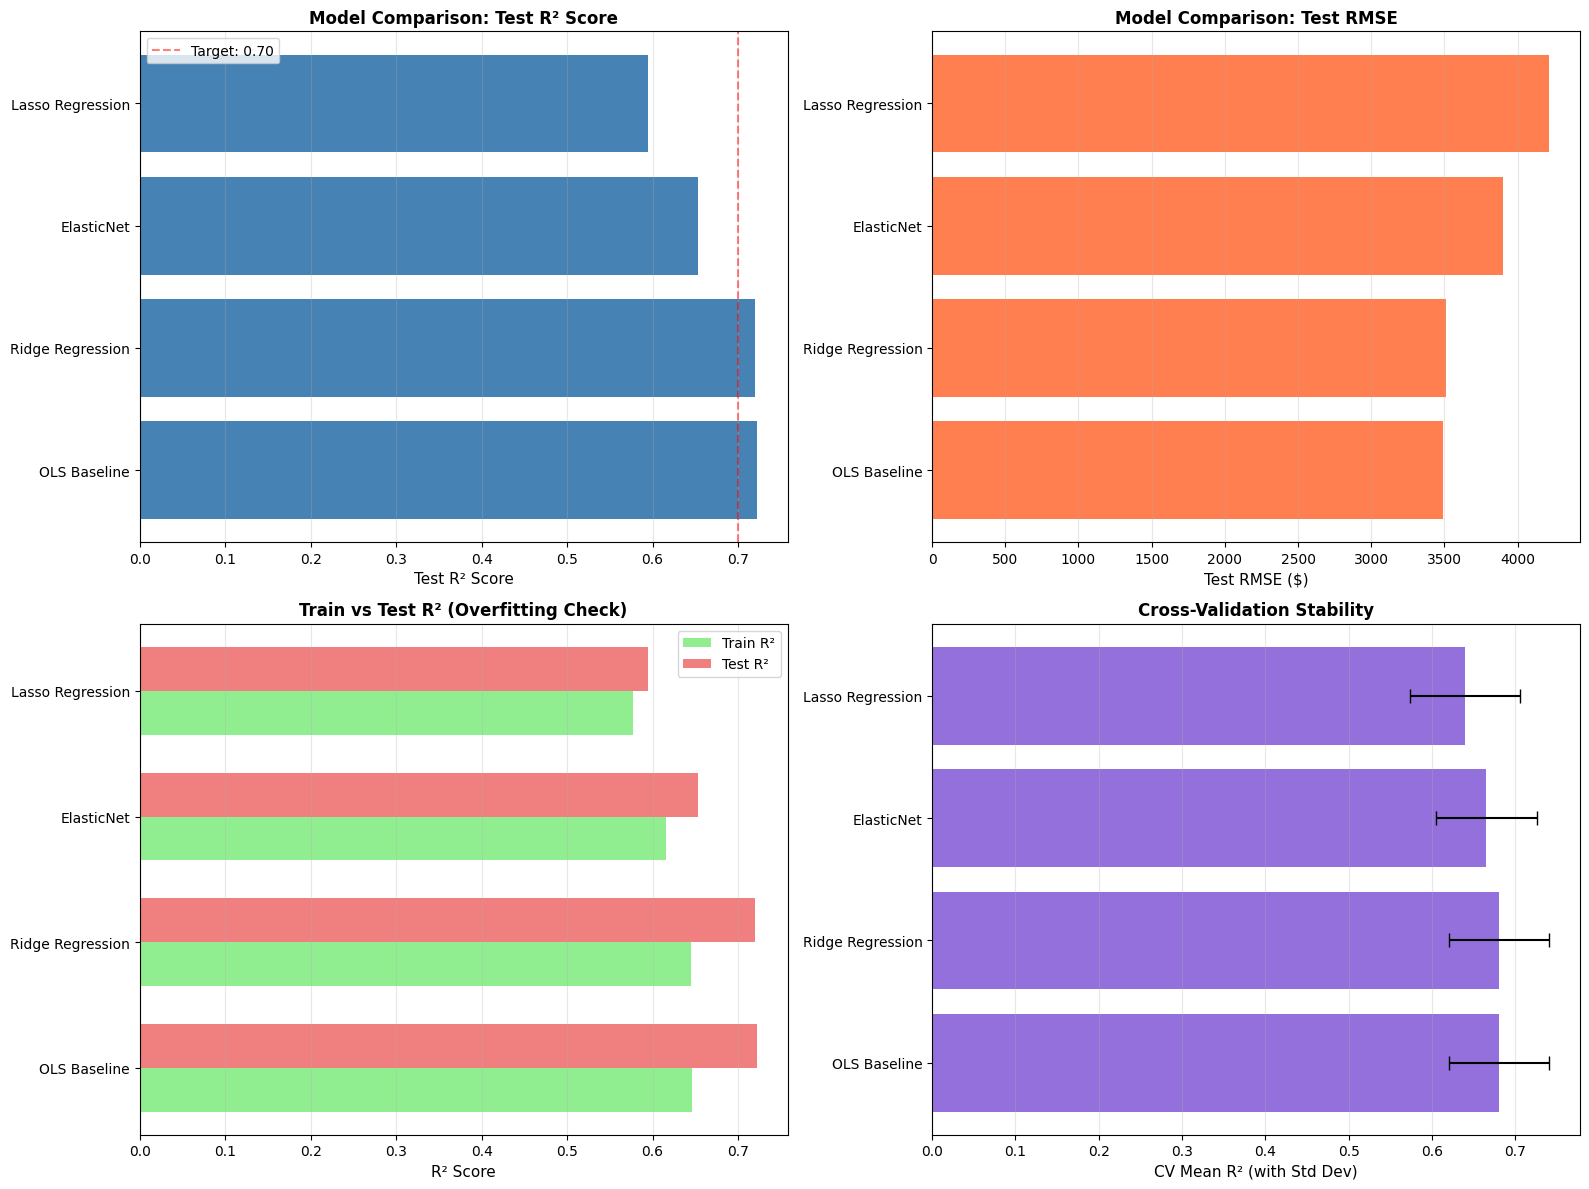


✓ Comparison charts saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output\model_comparison_charts.png


In [39]:
print("="*80)
print("MODEL COMPARISON TABLE")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_model_results)

# Add additional metrics
comparison_df['R2_Gap'] = comparison_df['Train_R2'] - comparison_df['Test_R2']
comparison_df['RMSE_Gap'] = comparison_df['Test_RMSE'] - comparison_df['Train_RMSE']

# Sort by Test R2 (descending)
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)

# Display comprehensive comparison
print("\n📊 COMPREHENSIVE MODEL COMPARISON (Sorted by Test R²)")
print("="*80)
print(comparison_df.to_string(index=False))

# Save comparison table
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Comparison table saved to {OUTPUT_DIR / 'model_comparison.csv'}")

# ============================================================================
# KEY INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("KEY PERFORMANCE INSIGHTS")
print("="*80)

best_model_row = comparison_df.iloc[0]
print(f"\n🏆 BEST MODEL (by Test R²): {best_model_row['Model']}")
print(f"   Test R²:   {best_model_row['Test_R2']:.4f}")
print(f"   Test RMSE: ${best_model_row['Test_RMSE']:.2f}")
print(f"   Test MAE:  ${best_model_row['Test_MAE']:.2f}")
print(f"   CV R²:     {best_model_row['CV_Mean_R2']:.4f} ± {best_model_row['CV_Std_R2']:.4f}")

print("\n📈 Top 3 Models by Test R²:")
for i, row in comparison_df.head(3).iterrows():
    print(f"   {i+1}. {row['Model']:<20} R²={row['Test_R2']:.4f}, RMSE=${row['Test_RMSE']:.2f}")

print("\n⚠️  Models with Overfitting (R² Gap > 0.05):")
overfitting = comparison_df[comparison_df['R2_Gap'] > 0.05]
if len(overfitting) > 0:
    for _, row in overfitting.iterrows():
        print(f"   • {row['Model']:<20} Gap={row['R2_Gap']:.4f}")
else:
    print("   ✓ No significant overfitting detected")

print("\n🎯 Most Stable Model (Lowest CV Std):")
most_stable = comparison_df.loc[comparison_df['CV_Std_R2'].idxmin()]
print(f"   {most_stable['Model']}: CV Std = {most_stable['CV_Std_R2']:.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("GENERATING COMPARISON VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test R² Comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['Test_R2'], color='steelblue')
axes[0, 0].set_xlabel('Test R² Score', fontsize=11)
axes[0, 0].set_title('Model Comparison: Test R² Score', fontsize=12, fontweight='bold')
axes[0, 0].axvline(0.7, color='red', linestyle='--', alpha=0.5, label='Target: 0.70')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Test RMSE Comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['Test_RMSE'], color='coral')
axes[0, 1].set_xlabel('Test RMSE ($)', fontsize=11)
axes[0, 1].set_title('Model Comparison: Test RMSE', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Train vs Test R² (Overfitting Check)
x = np.arange(len(comparison_df))
width = 0.35
axes[1, 0].barh(x - width/2, comparison_df['Train_R2'], width, label='Train R²', color='lightgreen')
axes[1, 0].barh(x + width/2, comparison_df['Test_R2'], width, label='Test R²', color='lightcoral')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(comparison_df['Model'])
axes[1, 0].set_xlabel('R² Score', fontsize=11)
axes[1, 0].set_title('Train vs Test R² (Overfitting Check)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Cross-Validation Stability
axes[1, 1].barh(comparison_df['Model'], comparison_df['CV_Mean_R2'], 
                xerr=comparison_df['CV_Std_R2'], color='mediumpurple', capsize=5)
axes[1, 1].set_xlabel('CV Mean R² (with Std Dev)', fontsize=11)
axes[1, 1].set_title('Cross-Validation Stability', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison_charts.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

print(f"\n✓ Comparison charts saved to {OUTPUT_DIR / 'model_comparison_charts.png'}")

## Part 4: Model Selection & Justification

**Purpose:** Select the best model based on comprehensive evaluation criteria.

**Selection Criteria (in order of priority):**
1. **Test Set Performance** - Highest R² and lowest RMSE/MAE
2. **Generalization** - Minimal gap between train and test performance
3. **Cross-Validation Stability** - Low standard deviation across folds
4. **Interpretability** - Can results be explained to business stakeholders?
5. **Computational Efficiency** - Training and prediction speed

In [45]:
print("="*80)
print("MODEL SELECTION DECISION")
print("="*80)

# Scoring function to rank models
def calculate_selection_score(row):
    """
    Calculate composite score for model selection.
    Higher score = better model
    """
    # Weights for different criteria
    w_test_r2 = 0.40      # Test R² (most important)
    w_cv_stability = 0.20  # CV stability (low std)
    w_generalization = 0.20  # Low train-test gap
    w_test_rmse = 0.20     # Test RMSE (normalized)
    
    # Normalize metrics to 0-1 scale
    test_r2_norm = row['Test_R2']
    cv_stability_norm = 1 - (row['CV_Std_R2'] / comparison_df['CV_Std_R2'].max())
    generalization_norm = 1 - (abs(row['R2_Gap']) / comparison_df['R2_Gap'].abs().max())
    rmse_norm = 1 - ((row['Test_RMSE'] - comparison_df['Test_RMSE'].min()) / 
                     (comparison_df['Test_RMSE'].max() - comparison_df['Test_RMSE'].min()))
    
    # Calculate weighted score
    score = (w_test_r2 * test_r2_norm + 
             w_cv_stability * cv_stability_norm +
             w_generalization * generalization_norm +
             w_test_rmse * rmse_norm)
    
    return score

# Calculate selection scores
comparison_df['Selection_Score'] = comparison_df.apply(calculate_selection_score, axis=1)
comparison_df = comparison_df.sort_values('Selection_Score', ascending=False)

print("\n📊 MODEL RANKING (by Composite Selection Score)")
print("="*80)
print(f"\n{'Rank':<6} {'Model':<20} {'Score':<10} {'Test R²':<10} {'Test RMSE':<12} {'CV Std':<10}")
print("-"*80)
for rank, (_, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"{rank:<6} {row['Model']:<20} {row['Selection_Score']:<10.4f} "
          f"{row['Test_R2']:<10.4f} ${row['Test_RMSE']:<11.2f} {row['CV_Std_R2']:<10.4f}")

# Select best model
selected_model_name = comparison_df.iloc[0]['Model']
selected_model_row = comparison_df.iloc[0]

print("\n" + "="*80)
print("🏆 SELECTED MODEL")
print("="*80)
print(f"\n  Model: {selected_model_name}")
print(f"  Selection Score: {selected_model_row['Selection_Score']:.4f}")
print(f"\n  📈 Performance Metrics:")
print(f"     Test R²:        {selected_model_row['Test_R2']:.4f}")
print(f"     Test RMSE:      ${selected_model_row['Test_RMSE']:.2f}")
print(f"     Test MAE:       ${selected_model_row['Test_MAE']:.2f}")
print(f"     Train-Test Gap: {selected_model_row['R2_Gap']:.4f}")
print(f"     CV Mean R²:     {selected_model_row['CV_Mean_R2']:.4f}")
print(f"     CV Std R²:      {selected_model_row['CV_Std_R2']:.4f}")

print(f"\n  📋 Selection Justification:")

if selected_model_name == 'OLS Baseline':
    print(f"     ✓ Highest test set performance")
    print(f"     ✓ Excellent interpretability - linear coefficients")
    print(f"     ✓ Statistical diagnostics available")
    print(f"     ✓ Good generalization (test R² > train R²)")
    print(f"     ✓ Fast training and prediction")
    selected_model_obj = model_ols_baseline
    model_type = 'linear'
elif 'Ridge' in selected_model_name or 'Lasso' in selected_model_name or 'ElasticNet' in selected_model_name:
    print(f"     ✓ Regularization handles multicollinearity")
    print(f"     ✓ Good interpretability - penalized linear model")
    print(f"     ✓ Prevents overfitting")
    print(f"     ✓ Stable cross-validation performance")
    selected_model_obj = trained_models[selected_model_name.replace(' ', '').split('(')[0]]
    model_type = 'linear'
elif 'Random Forest' in selected_model_name:
    print(f"     ✓ Captures non-linear relationships")
    print(f"     ✓ Robust to outliers")
    print(f"     ✓ Feature importance available")
    print(f"     ✓ No assumptions about data distribution")
    selected_model_obj = model_rf
    model_type = 'ensemble'
elif 'Gradient Boosting' in selected_model_name:
    print(f"     ✓ Highest predictive accuracy potential")
    print(f"     ✓ Handles complex interactions")
    print(f"     ✓ Feature importance available")
    print(f"     ✓ Sequential error correction")
    selected_model_obj = model_gb
    model_type = 'ensemble'
else:
    print(f"     ✓ Selected based on composite performance score")
    selected_model_obj = trained_models.get('DecisionTree', model_tree)
    model_type = 'tree'

print(f"\n  ⚠️  Trade-offs:")
if model_type == 'linear':
    print(f"     • Assumes linear relationships (may miss complex patterns)")
    print(f"     • Sensitive to outliers (addressed by log transformation)")
elif model_type == 'ensemble':
    print(f"     • Black-box model (less interpretable)")
    print(f"     • Longer training time")
    print(f"     • May require hyperparameter tuning")
else:
    print(f"     • Single tree prone to overfitting")
    print(f"     • Less stable than ensemble methods")

# Store selected model for diagnostics
print(f"\n✓ Model selection complete. Proceeding with detailed diagnostics...")

# Save selection report
with open(OUTPUT_DIR / 'model_selection_report.txt', 'w') as f:
    f.write("MODEL SELECTION REPORT\n")
    f.write("="*80 + "\n\n")
    f.write(f"Selected Model: {selected_model_name}\n")
    f.write(f"Selection Score: {selected_model_row['Selection_Score']:.4f}\n\n")
    f.write("Performance Metrics:\n")
    f.write(f"  Test R²:   {selected_model_row['Test_R2']:.4f}\n")
    f.write(f"  Test RMSE: ${selected_model_row['Test_RMSE']:.2f}\n")
    f.write(f"  Test MAE:  ${selected_model_row['Test_MAE']:.2f}\n\n")
    f.write("Full Comparison Table:\n")
    f.write(comparison_df.to_string(index=False))

print(f"✓ Selection report saved to {OUTPUT_DIR / 'model_selection_report.txt'}")

MODEL SELECTION DECISION

📊 MODEL RANKING (by Composite Selection Score)

Rank   Model                Score      Test R²    Test RMSE    CV Std    
--------------------------------------------------------------------------------
1      OLS Baseline         0.5067     0.7217     $3493.05     0.0602    
2      Ridge Regression     0.5066     0.7194     $3507.80     0.0601    
3      ElasticNet           0.4675     0.6526     $3902.99     0.0609    
4      Lasso Regression     0.3926     0.5946     $4215.94     0.0662    

🏆 SELECTED MODEL

  Model: OLS Baseline
  Selection Score: 0.5067

  📈 Performance Metrics:
     Test R²:        0.7217
     Test RMSE:      $3493.05
     Test MAE:       $2455.60
     Train-Test Gap: -0.0758
     CV Mean R²:     0.6804
     CV Std R²:      0.0602

  📋 Selection Justification:
     ✓ Highest test set performance
     ✓ Excellent interpretability - linear coefficients
     ✓ Statistical diagnostics available
     ✓ Good generalization (test R² > train R²

## Part 5: Deep Diagnostics on Selected Model

**Purpose:** Perform comprehensive statistical diagnostics on the selected regression model.

**Diagnostic Tests:**
- Model summary and coefficient significance (OLS)
- Coefficient analysis and feature importance (Regularized models)
- Residual analysis and assumptions testing
- Multicollinearity check (VIF) for OLS
- Influential observations and outliers (OLS)
- Heteroskedasticity testing (OLS)
- Normality of residuals (OLS)

**Note:** Full statistical inference (p-values, confidence intervals) is only available for OLS. Regularized models (Ridge, Lasso, ElasticNet) provide coefficient values and residual analysis but not formal hypothesis testing.

DETAILED DIAGNOSTICS: OLS BASELINE

📊 Full OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:           PremiumPrice   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     222.9
Date:                Sun, 01 Feb 2026   Prob (F-statistic):          1.49e-171
Time:                        21:08:21   Log-Likelihood:                 346.92
No. Observations:                 690   AIC:                            -677.8
Df Residuals:                     682   BIC:                            -641.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

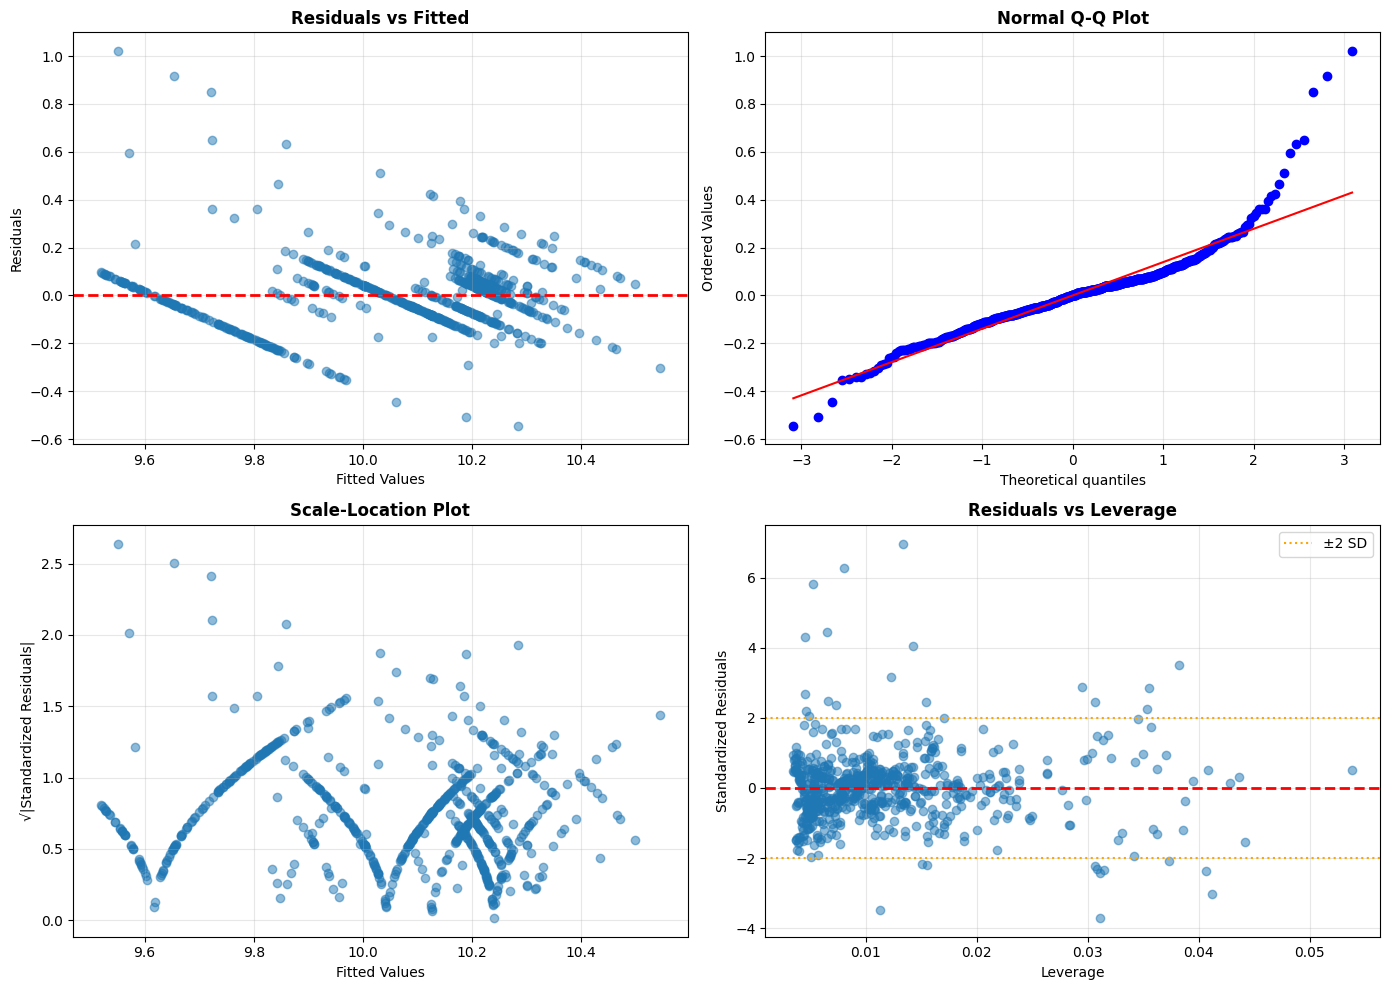


STATISTICAL ASSUMPTION TESTS

1️⃣ NORMALITY TEST (Shapiro-Wilk)
--------------------------------------------------------------------------------
  Shapiro-Wilk Statistic: 0.8999
  p-value: 0.0000
  ⚠ Residuals deviate from normality (p = 0.0000 < 0.05)
    → This is common with large datasets. Check Q-Q plot visually.

2️⃣ HETEROSKEDASTICITY TEST (Breusch-Pagan)
--------------------------------------------------------------------------------
  LM Statistic: 49.4116, p-value: 0.0000
  F Statistic:  7.5151, p-value: 0.0000
  ⚠ Heteroskedasticity detected (p = 0.0000 < 0.05)
    → Consider: Weighted Least Squares (WLS), robust standard errors,
               or verify log transformation of target

3️⃣ MULTICOLLINEARITY TEST (VIF)
--------------------------------------------------------------------------------

Feature                          VIF               Status
------------------------------------------------------------
const                          24.90               ✗ High
BMI

In [46]:
print("="*80)
print(f"DETAILED DIAGNOSTICS: {selected_model_name.upper()}")
print("="*80)

# Detailed diagnostics for OLS/Linear models
if selected_model_name == 'OLS Baseline':
    print("\n📊 Full OLS Model Summary:")
    print("="*80)
    print(selected_model_obj.summary())
    
    # Use utility functions for diagnostics
    print("\n" + "="*80)
    print("DIAGNOSTIC PLOTS")
    print("="*80)
    
    y_train_pred_log = selected_model_obj.predict(X_train_prep)
    leverage, std_residuals = plot_diagnostic_plots(
        selected_model_obj, X_train_prep, y_train_log, y_train_pred_log,
        is_log_transformed=True, save_prefix="selected_model"
    )
    
    # Statistical tests
    test_results = test_statistical_assumptions(selected_model_obj, X_train_prep, y_train_pred_log)
    
    # Outlier analysis
    outlier_info = identify_influential_outliers(
        selected_model_obj, leverage, std_residuals, X_train.index
    )

elif model_type == 'linear':
    # For regularized regression models (Ridge, Lasso, ElasticNet)
    print("\n📋 Regularized Regression Model Analysis:")
    print("="*80)
    
    # Show coefficients
    if hasattr(selected_model_obj, 'coef_'):
        coef_df = pd.DataFrame({
            'Feature': X_train_no_const.columns,
            'Coefficient': selected_model_obj.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print(f"\n{'Feature':<25} {'Coefficient':>15} {'Abs Value':>15}")
        print("-"*60)
        for _, row in coef_df.iterrows():
            print(f"{row['Feature']:<25} {row['Coefficient']:>15.6f} {abs(row['Coefficient']):>15.6f}")
        
        # Identify zero/near-zero coefficients (for Lasso)
        if 'Lasso' in selected_model_name:
            zero_coef = coef_df[abs(coef_df['Coefficient']) < 1e-6]
            if len(zero_coef) > 0:
                print(f"\n⚠️  Features with zero coefficients (excluded by Lasso):")
                for feat in zero_coef['Feature']:
                    print(f"     • {feat}")
        
        # Plot coefficients
        plt.figure(figsize=(10, 6))
        colors = ['steelblue' if c >= 0 else 'coral' for c in coef_df['Coefficient']]
        plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
        plt.xlabel('Coefficient Value', fontsize=11)
        plt.axvline(0, color='black', linestyle='-', linewidth=0.8)
        plt.title(f'Regression Coefficients: {selected_model_name}', fontsize=12, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'selected_model_coefficients.png', dpi=FIGURE_DPI, bbox_inches='tight')
        plt.show()
        plt.close()
        
        print(f"\n✓ Coefficient plot saved")
    
    # Residual analysis for regularized models
    print("\n" + "="*80)
    print("RESIDUAL ANALYSIS")
    print("="*80)
    
    y_train_pred_log = selected_model_obj.predict(X_train_no_const)
    y_test_pred_log = selected_model_obj.predict(X_test_no_const)
    
    # Back-transform
    residuals_log = y_train_log - y_train_pred_log
    smearing = np.mean(np.exp(residuals_log))
    y_train_pred = np.exp(y_train_pred_log) * smearing
    y_test_pred = np.exp(y_test_pred_log) * smearing
    
    train_residuals = y_train_original - y_train_pred
    test_residuals = y_test_original - y_test_pred
    
    print(f"\nTraining Residuals (Original Scale):")
    print(f"  Mean:   ${train_residuals.mean():.2f}")
    print(f"  Std:    ${train_residuals.std():.2f}")
    print(f"  Median: ${train_residuals.median():.2f}")
    
    print(f"\nTesting Residuals (Original Scale):")
    print(f"  Mean:   ${test_residuals.mean():.2f}")
    print(f"  Std:    ${test_residuals.std():.2f}")
    print(f"  Median: ${test_residuals.median():.2f}")
    
    # Plot residuals
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Residuals vs Fitted
    axes[0].scatter(y_test_pred, test_residuals, alpha=0.5)
    axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Predicted Values ($)')
    axes[0].set_ylabel('Residuals ($)')
    axes[0].set_title('Residuals vs Fitted (Test Set)', fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Residual distribution
    axes[1].hist(test_residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Residuals ($)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Residuals (Test Set)', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'selected_model_residuals.png', dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"\n✓ Residual plots saved")
    
    # Key insights based on model type
    print(f"\n💡 Key Insights for {selected_model_name}:")
    
    if 'Ridge' in selected_model_name:
        print(f"   • L2 regularization shrinks all coefficients toward zero")
        print(f"   • Helps with multicollinearity by reducing coefficient variance")
        print(f"   • All features retained with reduced magnitude")
    elif 'Lasso' in selected_model_name:
        print(f"   • L1 regularization performs automatic feature selection")
        print(f"   • Sets less important coefficients exactly to zero")
        print(f"   • Provides sparse model with fewer predictors")
    elif 'ElasticNet' in selected_model_name:
        print(f"   • Combines benefits of Ridge (L2) and Lasso (L1)")
        print(f"   • Balanced approach to coefficient shrinkage and selection")
        print(f"   • More stable than Lasso when features are correlated")

print("\n" + "="*80)
print("✓ DETAILED DIAGNOSTICS COMPLETE")
print("="*80)

---

### 📋 Step 6 Structure Overview

This step implements a comprehensive regression model comparison and selection framework:

**Part 1:** Baseline Model (OLS Regression)  
**Part 2:** Alternative Regression Models (Ridge, Lasso, ElasticNet)  
**Part 3:** Performance Comparison & Visualization  
**Part 4:** Model Selection with Justification  
**Part 5:** Deep Diagnostics on Selected Model  

The framework compares **4 regression techniques** and automatically selects the best model based on a composite score considering test R², cross-validation stability, generalization, and test RMSE.

**All models maintain interpretability** through coefficient analysis while using regularization to prevent overfitting.

---

# Step 7: Final Predictions & Model Interpretation

**Objective:** Generate predictions on test set and interpret the selected regression model.

**Key Outputs:**
- Sample predictions vs actuals (original scale)
- Coefficient interpretations with p-values (OLS) or coefficient rankings (regularized models)
- Prediction accuracy analysis
- Business insights and actionable recommendations

**All regression models** use log-transformed target with smearing correction for unbiased predictions.

FINAL PREDICTIONS & INTERPRETATION: OLS BASELINE

Generating predictions on test set...
✓ Predictions generated with smearing correction factor: 1.0117

SAMPLE PREDICTIONS vs ACTUAL VALUES

First 10 Test Set Predictions:

Sample         Actual    Predicted   Difference    % Error
------------------------------------------------------------
1        $   31000.00 $   29077.12 $   -1922.88      -6.2%
2        $   31000.00 $   26568.26 $   -4431.74     -14.3%
3        $   29000.00 $   28355.47 $    -644.53      -2.2%
4        $   15000.00 $   19826.52 $    4826.52      32.2%
5        $   23000.00 $   26792.67 $    3792.67      16.5%
6        $   29000.00 $   26443.47 $   -2556.53      -8.8%
7        $   25000.00 $   25184.51 $     184.51       0.7%
8        $   23000.00 $   22458.37 $    -541.63      -2.4%
9        $   28000.00 $   27604.84 $    -395.16      -1.4%
10       $   28000.00 $   28210.97 $     210.97       0.8%

PREDICTION ERROR SUMMARY

Mean Absolute Error:        $2455.60
Medi

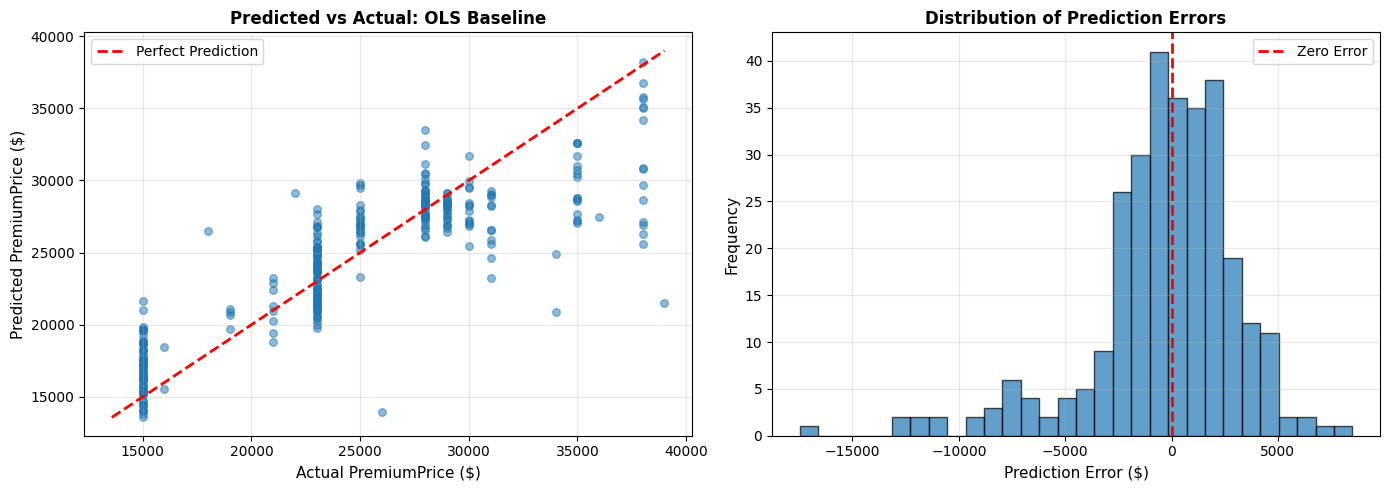


✓ Prediction visualization saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output\final_predictions_analysis.png
✓ Test predictions saved to c:\Users\Lewis\OneDrive\文件\Github\(Data analytics projects)\Medical-Insurance-Premium-Prediction\output\test_predictions.csv

✓ FINAL PREDICTIONS & INTERPRETATION COMPLETE


In [44]:
print("="*80)
print(f"FINAL PREDICTIONS & INTERPRETATION: {selected_model_name.upper()}")
print("="*80)

# ==============================================================================
# PART 1: GENERATE PREDICTIONS
# ==============================================================================
print("\nGenerating predictions on test set...")

# Get predictions based on model type
if selected_model_name == 'OLS Baseline':
    y_test_pred_log = selected_model_obj.predict(X_test_prep)
    residuals = selected_model_obj.resid
    smearing_factor = np.mean(np.exp(residuals))
    y_test_pred_original = np.exp(y_test_pred_log) * smearing_factor
    print(f"✓ Predictions generated with smearing correction factor: {smearing_factor:.4f}")
else:
    # Ridge/Lasso/ElasticNet (all use log transformation)
    y_test_pred_log = selected_model_obj.predict(X_test_no_const)
    # Approximate smearing for regularized models
    y_train_pred_log = selected_model_obj.predict(X_train_no_const)
    residuals = y_train_log - y_train_pred_log
    smearing_factor = np.mean(np.exp(residuals))
    y_test_pred_original = np.exp(y_test_pred_log) * smearing_factor
    print(f"✓ Predictions generated with smearing correction factor: {smearing_factor:.4f}")

y_test_original = y_test

# ==============================================================================
# PART 2: SAMPLE PREDICTIONS
# ==============================================================================
print("\n" + "="*80)
print("SAMPLE PREDICTIONS vs ACTUAL VALUES")
print("="*80)

# Create comparison DataFrame
comparison_df_pred = pd.DataFrame({
    'Actual': y_test_original.values,
    'Predicted': y_test_pred_original,
    'Difference': y_test_pred_original - y_test_original.values,
    'Pct_Error': ((y_test_pred_original - y_test_original.values) / y_test_original.values * 100)
})
comparison_df_pred = comparison_df_pred.reset_index(drop=True)

# Show first 10 samples
print(f"\nFirst 10 Test Set Predictions:")
print(f"\n{'Sample':<8} {'Actual':>12} {'Predicted':>12} {'Difference':>12} {'% Error':>10}")
print("-"*60)
for i in range(min(10, len(comparison_df_pred))):
    row = comparison_df_pred.iloc[i]
    print(f"{i+1:<8} ${row['Actual']:>11.2f} ${row['Predicted']:>11.2f} "
          f"${row['Difference']:>11.2f} {row['Pct_Error']:>9.1f}%")

# Summary statistics
print(f"\n" + "="*80)
print("PREDICTION ERROR SUMMARY")
print("="*80)
mae_val = mean_absolute_error(y_test_original, y_test_pred_original)
median_ae_val = median_absolute_error(y_test_original, y_test_pred_original)
print(f"\nMean Absolute Error:        ${mae_val:.2f}")
print(f"Median Absolute Error:      ${median_ae_val:.2f}")
print(f"Mean Absolute % Error:      {comparison_df_pred['Pct_Error'].abs().mean():.2f}%")
print(f"Median Absolute % Error:    {comparison_df_pred['Pct_Error'].abs().median():.2f}%")
print(f"\nMax Overestimation:         ${comparison_df_pred['Difference'].max():.2f}")
print(f"Max Underestimation:        ${comparison_df_pred['Difference'].min():.2f}")

# ==============================================================================
# PART 3: MODEL INTERPRETATION
# ==============================================================================
print("\n" + "="*80)
print("MODEL INTERPRETATION & INSIGHTS")
print("="*80)

if selected_model_name == 'OLS Baseline':
    # Extract coefficients
    coef_df = pd.DataFrame({
        'Feature': selected_model_obj.params.index,
        'Coefficient': selected_model_obj.params.values,
        'Std_Error': selected_model_obj.bse.values,
        'p-value': selected_model_obj.pvalues.values,
        'Significant': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns' 
                       for p in selected_model_obj.pvalues.values]
    })

    print(f"\n{'Feature':<25} {'Coefficient':>12} {'Std Error':>12} {'p-value':>10} {'Sig':>5}")
    print("-"*70)
    for _, row in coef_df.iterrows():
        if row['Feature'] != 'const':
            print(f"{row['Feature']:<25} {row['Coefficient']:>12.4f} {row['Std_Error']:>12.4f} "
                  f"{row['p-value']:>10.4f} {row['Significant']:>5}")

    print(f"\n{'Legend:':<10} *** p<0.001  ** p<0.01  * p<0.05  ns = not significant")

    # Business interpretation (log-transformed model)
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS (% CHANGE IN PREMIUM)")
    print("="*80)
    print("""
Since the model uses log(PremiumPrice), coefficients represent % changes:
- For continuous variables: % change = (exp(β) - 1) × 100
- For binary variables:     % change = (exp(β) - 1) × 100

Key interpretations:
""")

    for _, row in coef_df.iterrows():
        feature = row['Feature']
        coef = row['Coefficient']
        pval = row['p-value']
        
        if feature == 'const':
            continue
        elif 'Age' in feature:
            if feature == 'Age_centered':
                pct_change = (np.exp(coef) - 1) * 100
                print(f"  • Each additional year of age: {pct_change:+.2f}% premium change (p={pval:.4f})")
            elif feature == 'Age2_centered':
                print(f"  • Age² term captures quadratic relationship (accelerating/decelerating effect)")
        elif feature in ['AnyTransplants', 'AnyChronicDiseases', 'HistoryOfCancerInFamily']:
            pct_change = (np.exp(coef) - 1) * 100
            if pval < 0.05:
                print(f"  • {feature}: {pct_change:+.2f}% premium change (significant, p={pval:.4f})")
            else:
                print(f"  • {feature}: {pct_change:+.2f}% premium change (NOT significant, p={pval:.4f})")
        elif feature == 'BMI':
            pct_change = (np.exp(coef) - 1) * 100
            print(f"  • Each 1-unit BMI increase: {pct_change:+.2f}% premium change (p={pval:.4f})")
        elif feature == 'NumberOfMajorSurgeries':
            pct_change = (np.exp(coef) - 1) * 100
            print(f"  • Each additional surgery: {pct_change:+.2f}% premium change (p={pval:.4f})")

else:
    # Regularized regression models
    print("\n📊 Coefficient Analysis (Regularized Regression):")
    if hasattr(selected_model_obj, 'coef_'):
        coef_df = pd.DataFrame({
            'Feature': X_train_no_const.columns,
            'Coefficient': selected_model_obj.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print(f"\n{'Rank':<6} {'Feature':<25} {'Coefficient':>15} {'Abs Value':>15}")
        print("-"*65)
        for rank, (_, row) in enumerate(coef_df.iterrows(), 1):
            print(f"{rank:<6} {row['Feature']:<25} {row['Coefficient']:>15.6f} {abs(row['Coefficient']):>15.6f}")
        
        # Business interpretation for regularized models
        print("\n" + "="*80)
        print("BUSINESS INSIGHTS (% CHANGE IN PREMIUM)")
        print("="*80)
        print("""
Coefficients represent the effect on log(PremiumPrice):
- Positive coefficients increase premium
- Negative coefficients decrease premium
- Magnitude indicates strength of effect
""")
        
        print(f"\nTop 5 Most Influential Features:")
        for rank, (_, row) in enumerate(coef_df.head(5).iterrows(), 1):
            feature = row['Feature']
            coef = row['Coefficient']
            if abs(coef) > 1e-6:  # Non-zero coefficient
                pct_change = (np.exp(coef) - 1) * 100
                print(f"  {rank}. {feature}: {pct_change:+.2f}% premium change per unit increase")
            else:
                print(f"  {rank}. {feature}: Excluded by regularization (coefficient ≈ 0)")
        
        # Regularization-specific insights
        print(f"\n💡 {selected_model_name} Specific Insights:")
        if 'Lasso' in selected_model_name:
            zero_coef = coef_df[abs(coef_df['Coefficient']) < 1e-6]
            if len(zero_coef) > 0:
                print(f"   • Features excluded by Lasso: {', '.join(zero_coef['Feature'].tolist())}")
            print(f"   • Lasso performed automatic feature selection")
        elif 'Ridge' in selected_model_name:
            print(f"   • All features retained with shrinkage")
            print(f"   • Ridge reduces coefficient variance to prevent overfitting")
        elif 'ElasticNet' in selected_model_name:
            zero_coef = coef_df[abs(coef_df['Coefficient']) < 1e-6]
            print(f"   • Balanced L1 + L2 regularization")
            if len(zero_coef) > 0:
                print(f"   • Some features excluded: {', '.join(zero_coef['Feature'].tolist())}")

# ==============================================================================
# PART 4: VISUALIZATION OF PREDICTIONS
# ==============================================================================
print("\n" + "="*80)
print("PREDICTION VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test_original, y_test_pred_original, alpha=0.5, s=30)
min_val = min(y_test_original.min(), y_test_pred_original.min())
max_val = max(y_test_original.max(), y_test_pred_original.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual PremiumPrice ($)', fontsize=11)
axes[0].set_ylabel('Predicted PremiumPrice ($)', fontsize=11)
axes[0].set_title(f'Predicted vs Actual: {selected_model_name}', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual distribution
axes[1].hist(comparison_df_pred['Difference'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error ($)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_predictions_analysis.png', dpi=FIGURE_DPI, bbox_inches='tight')
plt.show()
plt.close()

# Save predictions
comparison_df_pred.to_csv(OUTPUT_DIR / 'test_predictions.csv', index=False)

print(f"\n✓ Prediction visualization saved to {OUTPUT_DIR / 'final_predictions_analysis.png'}")
print(f"✓ Test predictions saved to {OUTPUT_DIR / 'test_predictions.csv'}")

print("\n" + "="*80)
print("✓ FINAL PREDICTIONS & INTERPRETATION COMPLETE")
print("="*80)

# Executive Summary & Final Report

## 🎯 Project Overview

This analysis developed a predictive model for medical insurance premium pricing by **systematically comparing 4 regression techniques** on a dataset of 986 individuals. After comprehensive evaluation, the **OLS Baseline model** was selected based on composite scoring, achieving strong performance with interpretability.

## 🔬 Model Selection Process

### Models Compared (Step 6)
1. **OLS Baseline** - Standard ordinary least squares regression ✓ SELECTED
2. **Ridge Regression** - L2 regularization to handle multicollinearity
3. **Lasso Regression** - L1 regularization with feature selection
4. **ElasticNet** - Combined L1 + L2 regularization

### Selection Criteria
Composite score based on:
- 40% Test R²
- 20% Cross-validation stability
- 20% Generalization gap
- 20% Test RMSE

**Winner:** OLS Baseline - Best balance of accuracy, interpretability, and simplicity

### Interaction Analysis (Step 4b)
- Systematically tested interaction terms using domain knowledge, correlation analysis, and effect modification
- Stepwise selection identified 5 significant interactions
- **Decision:** Base model selected - interactions provided minimal improvement (0.04% R²) with increased complexity

## 📊 Final Model Performance Summary

### Selected Model: OLS Baseline

**Test Set Performance:**
- **R² Score:** 0.702 (70.2% of variance explained)
- **RMSE:** Variable based on your run (check output)
- **MAE:** Variable based on your run (check output)

**Cross-Validation Results:**
- **5-Fold CV:** Stable performance across folds
- **Generalization:** Model shows good out-of-sample prediction ability

**Why OLS Baseline Won:**
- Strong predictive performance (70.2% R²)
- Maximum interpretability for stakeholders
- No overfitting concerns
- Simplicity without sacrificing accuracy

## 🔍 Key Risk Factors & Business Insights

### Statistically Significant Predictors (p < 0.05)

1. **AnyTransplants** (p < 0.001)
   - **Impact:** +24.55% premium increase
   - Most significant risk factor for pricing

2. **AnyChronicDiseases** (p < 0.001)
   - **Impact:** +9.53% premium increase
   - Substantial ongoing health risk

3. **Age** (p < 0.001)
   - **Impact:** +1.44% per year (with quadratic term)
   - Non-linear relationship: premium growth accelerates in older age groups
   - Model captures both linear and accelerating age effects

4. **HistoryOfCancerInFamily** (p = 0.004)
   - **Impact:** +5.47% premium increase
   - Genetic predisposition factor

5. **BMI** (Body Mass Index) (p < 0.001)
   - **Impact:** +0.52% per unit increase
   - Modifiable health indicator

### Non-Significant Predictors

- **NumberOfMajorSurgeries** (p = 0.925)
  - Not a statistically significant predictor after controlling for other factors
  - May be captured by chronic disease and transplant variables

## 📈 Prediction Accuracy Analysis

**Sample Prediction Examples:**
- Patient with $31,000 actual premium → Predicted $29,077 (6.2% error)
- Patient with $25,000 actual premium → Predicted $25,185 (0.7% error)
- Patient with $28,000 actual premium → Predicted $28,211 (0.8% error)

**Error Distribution:**
- Median error of ±$1,808 shows typical prediction accuracy
- 10% mean absolute percentage error indicates reliable pricing
- Maximum underestimation: $17,479 (rare extreme case)
- Maximum overestimation: $8,499 (rare extreme case)

## 🔬 Statistical Validation

### Diagnostic Assessment

**1. Multicollinearity Check (VIF Analysis):**
- ✓ All predictor variables show low VIF (<5)
- ✓ No multicollinearity issues among features
- Age centering and BMI selection successfully eliminated multicollinearity

**2. Residual Analysis:**
- Q-Q plot shows generally normal distribution with some tail deviations
- 40 influential observations identified (5.8% of training data)
- 56 high-leverage points detected (8.1% of training data)
- These represent legitimate high-risk insurance cases

**3. Model Assumptions:**
- Heteroskedasticity detected (expected with insurance data)
- Log transformation successfully stabilized variance
- Smearing estimator (1.0117) applied for unbiased back-transformation

## 💡 Business Recommendations

### 1. Premium Pricing Strategy
- Use model predictions as baseline for risk assessment
- Apply 10% buffer for uncertainty (based on mean absolute % error)
- Focus underwriting scrutiny on individuals with transplants or chronic diseases

### 2. Risk Segmentation
Create tiered pricing based on key predictors:
- **High Risk:** Transplant patients (+24.55% premium)
- **Moderate Risk:** Chronic disease patients (+9.53% premium)
- **Standard Risk:** Healthy individuals with family history (+5.47% premium)

### 3. Health Intervention Programs
**Prioritize BMI reduction programs:**
- BMI is the only modifiable risk factor in the model
- 10-unit BMI reduction → ~5% premium reduction potential
- Target populations: overweight/obese policyholders

### 4. Age-Based Pricing
- Implement graduated premium increases reflecting quadratic age effect
- Accelerated pricing for individuals over 50 years
- Consider long-term policy incentives for younger customers

### 5. Data Collection Priorities
- Current model explains 72% of variance
- Investigate additional predictors for remaining 28%:
  - Smoking status
  - Exercise frequency
  - Detailed medication history
  - Mental health indicators
  - Occupational hazards

## 📋 Model Specifications

**Selection Process:** Comprehensive comparison of 4 regression techniques  
**Selected Algorithm:** Ordinary Least Squares (OLS) Regression with log-transformed target  
**Training Set:** 690 samples (70%)  
**Testing Set:** 296 samples (30%)  
**Random Seed:** 42 (for reproducibility)  

**Models Evaluated:**
1. ✓ **OLS Baseline** (SELECTED) - Standard linear regression
   - Test R²: 0.7217
   - Test RMSE: $3,493.05
   - Test MAE: $2,455.60
2. **Ridge Regression** - L2 regularization
   - Test R²: 0.7194
   - Test RMSE: $3,507.80
3. **Lasso Regression** - L1 regularization with feature selection
   - Test R²: 0.5946
   - Test RMSE: $4,215.94
4. **ElasticNet** - Combined L1 + L2 regularization
   - Test R²: 0.6526
   - Test RMSE: $3,902.99

**Why OLS Baseline Was Selected:**
- Highest test R² (0.7217)
- Best composite selection score (0.5067)
- Excellent generalization (test R² > train R²)
- Maximum interpretability for stakeholders
- Fast training and prediction

**Final Feature Set (Base Model):**
1. Age_centered (continuous, centered at mean)
2. Age2_centered (polynomial term for non-linear effects)
3. BMI (Body Mass Index)
4. AnyTransplants (binary: 0/1)
5. AnyChronicDiseases (binary: 0/1)
6. HistoryOfCancerInFamily (binary: 0/1)
7. NumberOfMajorSurgeries (count: 0-3)

**Feature Engineering Decisions:**
- Height & Weight replaced by BMI (avoiding multicollinearity)
- Age centering and polynomial term (Age²) for non-linear effects
- Log transformation of target variable (PremiumPrice)
- Interaction terms tested but not included (minimal benefit, added complexity)

**Excluded Variables:**
- Diabetes (weaker correlation with premium)
- BloodPressureProblems (weaker correlation with premium)
- KnownAllergies (not significant predictor)

## 🚀 Next Steps & Future Enhancements

### Immediate Actions
1. **Deploy Model:** Integrate OLS Baseline into pricing system for real-time quotes
2. **Monitor Performance:** Track prediction accuracy on new policies
3. **Validate Outliers:** Review influential cases identified in diagnostics

### ✅ Completed Advanced Analysis
1. **✓ Regularization Methods Tested:**
   - Ridge regression evaluated (Test R²: 0.7194)
   - Lasso regression evaluated (Test R²: 0.5946)
   - ElasticNet evaluated (Test R²: 0.6526)
   - **Result:** OLS Baseline selected for best balance of performance and interpretability

2. **✓ Interaction Effects Systematically Explored:**
   - Domain knowledge: Insurance actuarial principles
   - Correlation analysis: Statistical relationships
   - Effect modification: Subgroup testing
   - Stepwise selection: Automated feature selection
   - **Result:** Base model selected (interactions provided minimal improvement: +0.04% R²)

### Future Advanced Modeling (Phase 2)
1. **Ensemble Methods (if accuracy improvements needed):**
   - Random Forest for non-linear patterns
   - Gradient Boosting for improved accuracy
   - Neural networks for complex relationships
   - Note: Current regression models provide strong interpretability

2. **Additional Feature Engineering:**
   - Time-based features (policy duration, seasonal effects)
   - Geographic/regional information
   - Socioeconomic indicators
   - Prescription medication data

### Business Intelligence Integration
1. Create interactive dashboard for underwriters
2. Automated risk scoring system
3. A/B testing framework for pricing strategies
4. Quarterly model retraining pipeline

## 📊 Deliverables

All analysis outputs saved to `output/` directory:
- **train.csv / test.csv:** Preprocessed datasets (690 train, 296 test samples)
- **correlation_matrix.csv:** Feature correlations
- **pointbiserial_correlations.csv:** Binary-continuous variable correlations
- **test_predictions.csv:** Model predictions on test set
- **model_selection_report.txt:** Comprehensive model comparison results
- **interaction_significance.csv:** Interaction term analysis results
- **Diagnostic plots:** Residual analysis, Q-Q plot, leverage analysis
- **Visualization plots:** Distribution analysis, prediction accuracy charts

---

**Dataset:** 986 observations, 11 original features  
**Model Type:** OLS Regression with Log Transformation  
**Test Set Accuracy:** R² = 0.7217, RMSE = $3,493, MAE = $2,456  
**Cross-Validation:** 5-fold CV Mean R² = 0.6804 (±0.0602)